In [1]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)
import root_pandas,glob

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

import misc_util

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.22/06


In [2]:
#data_dihadrons = root_pandas.read_root(glob.glob("/home/sebouh/tuples_hadd/*_dihadrons*.root"))

In [6]:
data_dihadrons_inb = root_pandas.read_root(glob.glob("/home/sebouh/tuples_hadd/inb*_dihadrons*.root"))
data_dihadrons_outb = root_pandas.read_root(glob.glob("/home/sebouh/tuples_hadd/outb*_dihadrons*.root"))

In [ ]:
#inb_mix=read_n('/home/sebouh/tuples_hadd/inbend_mixed_50xx.root',len(data_dihadrons)*5)
#inb_mix.to_root('/home/sebouh/tuples_hadd/inbend_mixed_10.root')
#inb_mix = root_pandas.read_root('/home/sebouh/tuples_hadd/inbend_mixed_10.root')
#outb_mix = read_n('/home/sebouh/tuples_hadd/outbend_mixed_56xx.root',len(data_dihadrons))
#outb_mix.to_root('/home/sebouh/tuples_hadd/outbend_mixed_10.root')
#mixed = root_pandas.read_root(glob.glob('/home/sebouh/tuples_hadd/*_mixed_small.root'))

In [ ]:
#data_dihadrons = uproot3.open('../in/data_dihadrons_100pc.root')['dihadrons'].pandas.df()

In [3]:
mc_dihadrons_outb = root_pandas.read_root(glob.glob("/home/sebouh/tuples_hadd/mc_dihadrons_outb.root"),'dihadrons')
mc_dihadrons_inb = root_pandas.read_root(glob.glob("/home/sebouh/tuples_hadd/mc_dihadrons_inb.root"),'dihadrons')



In [7]:

q_pi_p = "h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and mx_eh1x > 1.665 and abs(h1_pid) ==211 and h2_z < 0.5"
pi_p_mXcut_inb = data_dihadrons_inb.query(q_pi_p)
pi_p_mXcut_outb = data_dihadrons_outb.query(q_pi_p)

q_pi_p_truth = q_pi_p.replace("h1_","h1_truth_").replace("h2_","h2_truth_").replace("mx_eh1x", "mx_eh1x_truth")
pi_p_mXcut_mc_inb = mc_dihadrons_inb.query(q_pi_p_truth)
pi_p_mXcut_mc_outb = mc_dihadrons_outb.query(q_pi_p_truth)


q_pi_pi = "h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and abs(h2_pid) == 211 and abs(h1_pid) ==211 and h2_z < 0.5"
pi_pi_inb = data_dihadrons_inb.query(q_pi_pi)
pi_pi_outb = data_dihadrons_outb.query(q_pi_pi)

q_pi_pi_truth = q_pi_pi.replace("h1_","h1_truth_").replace("h2_","h2_truth_").replace("mx_eh1x", "mx_eh1x_truth")
pi_pi_mc_inb = mc_dihadrons_inb.query(q_pi_pi_truth)
pi_pi_mc_outb = mc_dihadrons_outb.query(q_pi_pi_truth)


In [173]:
import gc
gc.collect()
def offset(a):
    return a+2*np.pi*(a<-np.pi/2)-2*np.pi*(a>=3*np.pi/2)
def get_v2(df,df_mc,projyrange=(1.5,2.5),bins=50,useMC=True):
    import scipy.optimize
    #radius = 0.3
    #M00 = len(df_mixed.query('sqrt(diff_rap_cm**2+diff_phi_cm**2)<%s'%radius))/(np.pi*radius**2)
    
    denom = len(df)*2*np.pi/bins
    if(denom == 0):
        return None
    y, x = np.histogram(offset(df.query("diff_rap_cm > %s and diff_rap_cm < %s" %projyrange).diff_phi_cm), bins=bins, range=(-np.pi/2,3*np.pi/2))
    x = np.add(x[1:],x[:-1])/2
    dy = np.sqrt(y)
    y=np.divide(y,denom)
    dy=np.divide(dy,denom)
    
    if useMC:
        qq = "diff_rap_cm_truth > %s and diff_rap_cm_truth < %s"  %projyrange
        for part in "e h1 h2".split():
            qq += " and part_truth_th < 45*3.14159/180 and part_truth_th > 5*3.14159/180".replace("part",part)
        mc_highy = df_mc.query(qq)

        yt, _ = np.histogram(offset(mc_highy.diff_phi_cm_truth), bins=bins, range=(-np.pi/2,3*np.pi/2))
        denom = np.sum(yt)*2*np.pi/bins
        if(denom == 0):
            return None
        dyt = np.sqrt(yt)
        yt=np.divide(yt,denom)
        dyt=np.divide(dyt,denom)

        ym, _ = np.histogram(offset(mc_highy.query("h2_p>0").diff_phi_cm_truth), bins=bins, range=(-np.pi/2,3*np.pi/2))
        dym = np.sqrt(ym)
        denom = np.sum(ym)*2*np.pi/bins
        if(denom == 0):
            return None
        ym=np.divide(ym,denom)
        dym=np.divide(dym,denom)

        safe = lambda a : a+1*(a==0)
        dyc = y*yt/safe(ym)*np.hypot(dy/safe(y), dym/safe(ym))+10*(ym==0)
        yc= y*yt/safe(ym)
    
    else :
        yc = y
        dyc = dy
        
    #b2 = 2*sum(y*np.cos(2*x))/len(x)
    #b0 = sum(y)/len(x)
    
    n=5
    if n==3:
        def f (xx,b0,b1,b2,b3):
            args=[b0,b1,b2,b3]
            tot = 0
            for i in range(len(args)):
                tot+=args[i]*np.cos(i*xx)
            return tot

    if n==4:
        def f (xx,b0,b1,b2,b3,b4):
            args=[b0,b1,b2,b3,b4]
            tot = 0
            for i in range(len(args)):
                tot+=args[i]*np.cos(i*xx)
            return tot
    if n==5:
        def f (xx,b0,b1,b2,b3,b4,b5):
            args=[b0,b1,b2,b3,b4,b5]
            tot = 0
            for i in range(len(args)):
                tot+=args[i]*np.cos(i*xx)
            return tot
    b,bcov = scipy.optimize.curve_fit(f, x, yc,sigma=dyc)
    
    
    
    return b[2]/b[0]/2, b[2]/b[0]*np.sqrt(bcov[0][0]/b[0]**2+bcov[2][2]/b[2]**2)/2
    

In [176]:
def v2_plot(dfs,dfs_mc, xvar, mn,mx,bins,label=None,useMC=True):
    
    x = []
    y = []
    dy = []
    for i in range(bins):
        yi = 0
        sum_W = 0
        for df,df_mc in zip(dfs,dfs_mc):
            q = "%s >= %s and %s < %s" % (xvar,mn+i*(mx-mn)/bins,xvar,mn+(i+1)*(mx-mn)/bins)
            s = df.query(q)
            
            if not "Q2_truth" in df_mc.columns:
                df_mc['Q2_truth'] = df_mc.eval("4*E*e_truth_p*sin(e_truth_th/2)**2")
            
            if not "x_truth" in df_mc.columns:
                df_mc['x_truth'] = df_mc.eval("Q2_truth/(2*.9383*(E-e_truth_p))")
            m = df_mc.query(q.replace("h1_","h1_truth_").replace("h2_","h2_truth_")\
                            .replace("Q2","Q2_truth").replace("x","x_truth"))
            
            if(len(s) == 0 or len(m) == 0):
                continue
            ret = get_v2(s,m,useMC=useMC)
            if ret is None:
                continue
            yii,dyii = ret
            import math
            yi +=yii/dyii**2
            sum_W+= 1/dyii**2
        if sum_W == 0:
            continue
        yi/= sum_W
        dyi = 1/np.sqrt(sum_W)
        if math.isnan(yi) or math.isnan(dyi) or dyi == 0 or yi==1 or abs(dyi)>0.04:
            continue
        x.append(mn+(i+0.5)*(mx-mn)/bins)
        y.append(yi)
        dy.append(dyi)
        
    plt.errorbar(x,y,dy,label=label,linestyle='-',color=None if useMC else '0.7')
    gc.collect()
    



/home/sebouh/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/sebouh/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


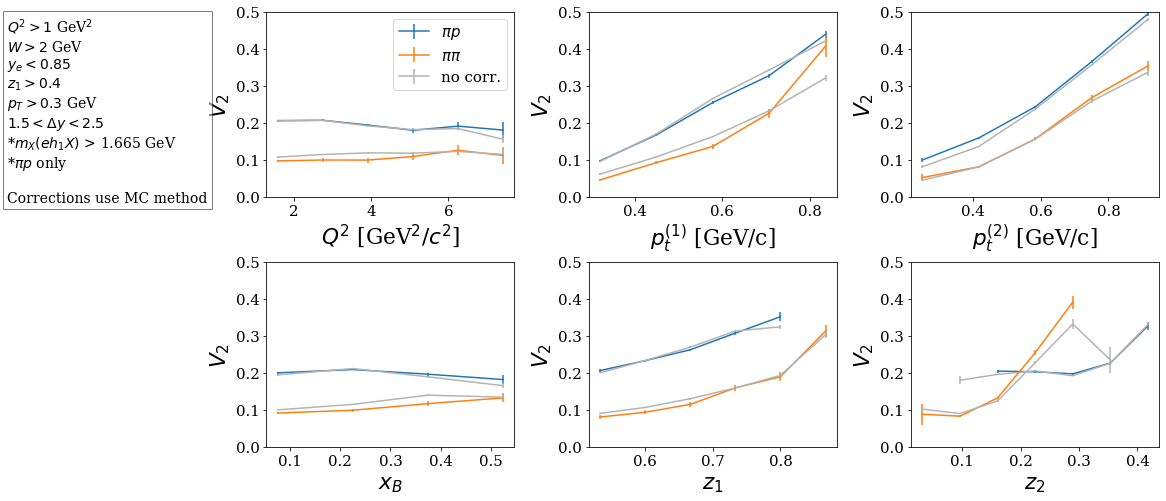

In [183]:
#v2 plots for presentation
dfs = [[pi_p_mXcut_inb,pi_p_mXcut_outb],[pi_pi_inb,pi_pi_outb]]
dfs_mixed = [[pi_p_mXcut_mc_inb,pi_p_mXcut_mc_outb], [pi_pi_mc_inb, pi_pi_mc_outb]]
labels = '$\pi p$;$\pi\pi$'.split(";")
#for q in "h2_pid == 2212 and abs(h1_pid) == 211","abs(h2_pid) == 211 and abs(h1_pid) == 211":
#    dfs.append(data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
#                             + " and " + q))
#    
#    dfs_mixed.append(mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
#                             + " and " + q))

fig, axs = plt.subplots(2,3, figsize=(16,8))    
fig.subplots_adjust(hspace=0.35,wspace=0.3)

plt.sca(axs[1][1])    
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h1_z', 0.5, 0.9, 6,label=label)
    v2_plot(df,df_mixed, 'h1_z', 0.5, 0.9, 6,useMC=False)
#plt.legend()
plt.gca().set_ylabel("$V_2$")
plt.gca().set_xlabel("$z_1$")


plt.sca(axs[1][2]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h2_z', 0, 0.45, 7,label=label)
    v2_plot(df,df_mixed, 'h2_z', 0, 0.45, 7,useMC=False)
#plt.legend()
plt.gca().set_ylabel("$V_2$")
plt.gca().set_xlabel("$z_2$")


plt.sca(axs[0][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h1_cm_pt', 0, .9, 7,label=label +" (with MC-based corr.)")
    v2_plot(df,df_mixed, 'h1_cm_pt', 0, .9, 7,useMC=False,label='no corrections' if label==labels[-1] else None)

plt.gca().set_ylabel("$V_2$")
plt.gca().set_xlabel("$p_t^{(1)}$ [GeV/c]")


plt.sca(axs[0][2]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h2_cm_pt', 0, 1, 6,label=label)
    v2_plot(df,df_mixed, 'h2_cm_pt', 0, 1, 6,useMC=False)
#plt.legend()
plt.gca().set_ylabel("$V_2$")
plt.gca().set_xlabel("$p_t^{(2)}$ [GeV/c]")


plt.sca(axs[1][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'x', 0, .6, 4,label=label)
    v2_plot(df,df_mixed, 'x', 0, .6, 4,useMC=False)
plt.gca().set_ylabel("$V_2$")
plt.gca().set_xlabel("$x_B$")

plt.sca(axs[0][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'Q2', 1, 8, 6,label=label +"")
    v2_plot(df,df_mixed, 'Q2', 1, 8, 6,useMC=False,label='no corr.' if label==labels[-1] else None)
plt.legend()
plt.gca().set_ylabel("$V_2$")
plt.gca().set_xlabel("$Q^2$ [GeV$^2/c^2$]")

for a in axs:
    for b in a:
        b.set_ylim(0,0.5)
        
fig.text(-0.1,0.55,"$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$y_e<0.85$\n$z_1>0.4$\n$p_T>0.3$ GeV\n$1.5<\Delta y<2.5$"+\
         "\n*$m_X(eh_1X)$ > 1.665 GeV\n*$\\pi p$ only\n\nCorrections use MC method",
         bbox=dict(facecolor='white', alpha=0.5),fontsize=14)

plt.savefig("../images/v2_vs_stuff1_mc.png",bbox_inches='tight')

In [4]:
bins = 50
def offset(a):
    return a+2*np.pi*(a<-np.pi/2)-2*np.pi*(a>=3*np.pi/2)
for i in (0,1):
    

    q = ("diff_rap_cm_truth > %s and diff_rap_cm_truth < %s" %(1.5,2.5)) 
    q += " and h2_truth_z<0.5 and h1_truth_p>0 and h2_truth_p>0  and h2_truth_z<h1_truth_z "
    q += " and h1_truth_cm_pt>0.3 and h2_truth_cm_pt>0.3 and abs(h1_truth_pid) ==211 and h1_truth_z > 0.4"

    for p in 'h1 h2 e'.split():
        q += " and part_truth_th < 45*3.14159/180 and part_truth_th > 5*3.14159/180".replace("part",p)

    
    if i == 1:
        q+= " and abs(h2_truth_pid) == 211"
        dfs = [df.query(q) for df in [mc_dihadrons_inb,mc_dihadrons_outb]]
    else :
        q+= " and h2_truth_pid == 2212"
        dfs = [df.query(q) for df in [mc_dihadrons_inb,mc_dihadrons_outb]]
    ys = []
    dys = []
    for df in dfs:
        df.eval('mx_eh1x_truth = sqrt((E+e_truth_p+.9383)**2-(-e_truth_px-h1_truth_px)**2'
                      +'-(-e_truth_py-h1_truth_py)**2-(E-e_truth_pz-h1_truth_pz)**2)')
        ysmc, x = np.histogram(offset(df.query("h2_cm_ph!=0").diff_phi_cm_truth), bins=bins, range=(-np.pi/2,3*np.pi/2))
        ysmc0 = ysmc
        
        x = np.add(x[1:],x[:-1])/2
        denom = sum(ysmc)*(x[1]-x[0])
        dysmc = np.sqrt(ysmc)
        #ysmc=np.divide(ysmc,denom)
        #dysmc=np.divide(dysmc,denom)
    
        
        yt,x = np.histogram(offset(df.diff_phi_cm_truth), bins=bins, range=(-np.pi/2,3*np.pi/2))
        x = np.add(x[1:],x[:-1])/2

        yt0 = yt
        denom = sum(yt)*(x[1]-x[0])
        #dyt=np.sqrt(yt)/denom
        #yt = yt/denom
        
        ys.append(yt/ysmc)
        dys.append(np.sqrt(ysmc0*(yt0-ysmc0))/yt0**(3/2))
    print("x =",list(x))    
    print("y = ",list((ys[0]/dys[0]**2+ys[1]/dys[1]**2)/(1/dys[0]**2+1/dys[1]**2)/(2*np.pi)))
    print("dy = ", list(np.sqrt(1/(1/dys[0]**2+1/dys[1]**2))/(2*np.pi)))

x = [-1.5079644737231006, -1.3823007675795091, -1.2566370614359172, -1.1309733552923253, -1.0053096491487339, -0.879645943005142, -0.7539822368615503, -0.6283185307179585, -0.5026548245743668, -0.37699111843077515, -0.25132741228718336, -0.12566370614359157, 1.1102230246251565e-16, 0.1256637061435919, 0.2513274122871837, 0.3769911184307754, 0.5026548245743672, 0.6283185307179588, 0.7539822368615505, 0.8796459430051422, 1.0053096491487339, 1.1309733552923258, 1.2566370614359175, 1.3823007675795091, 1.507964473723101, 1.6336281798666927, 1.7592918860102844, 1.8849555921538763, 2.0106192982974678, 2.1362830044410597, 2.2619467105846516, 2.387610416728243, 2.513274122871835, 2.638937829015427, 2.7646015351590183, 2.8902652413026098, 3.0159289474462017, 3.1415926535897936, 3.2672563597333855, 3.392920065876977, 3.5185837720205684, 3.6442474781641603, 3.769911184307752, 3.895574890451344, 4.0212385965949355, 4.1469023027385274, 4.272566008882119, 4.39822971502571, 4.523893421169303, 4.649557

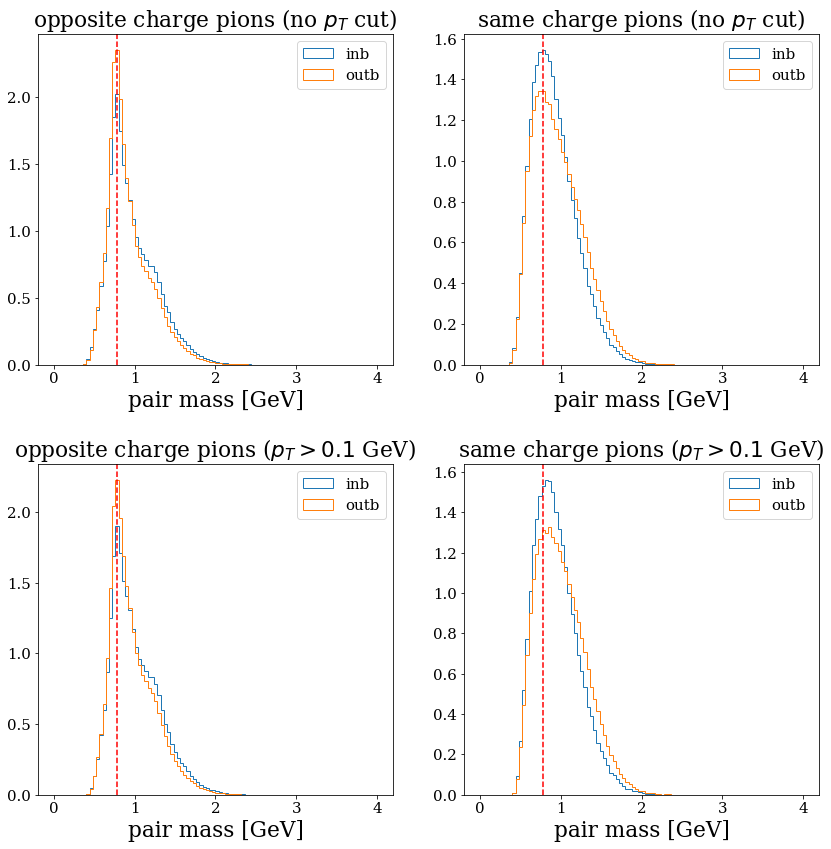

In [105]:

dfs = [data_dihadrons_inb.query("diff_rap_cm<2.5 and diff_rap_cm>1.5"), data_dihadrons_outb.query("diff_rap_cm<2.5 and diff_rap_cm>1.5")]
fig, axs = plt.subplots(2,2, figsize=(14,14))
fig.subplots_adjust(hspace=.3)

plt.sca(axs[0][0])
q = 'h1_pid != h2_pid and abs(h2_pid) ==211'
for df in dfs:
    plt.hist(df.query(q).pair_mass,density=True,bins=100,histtype='step',range=(0,4))
plt.gca().set_xlabel("pair mass [GeV]")
plt.gca().legend(labels='inb outb'.split())
plt.axvline(.7755,color='r',linestyle='--')
plt.gca().set_title("opposite charge pions (no $p_T$ cut)")


plt.sca(axs[0][1])
q = 'h1_pid == h2_pid and abs(h2_pid) ==211'
for df in dfs:
    plt.hist(df.query(q).pair_mass,density=True,bins=100,histtype='step',range=(0,4))
plt.gca().set_xlabel("pair mass [GeV]")
plt.gca().legend(labels='inb outb'.split())
plt.axvline(.7755,color='r',linestyle='--')
plt.gca().set_title("same charge pions (no $p_T$ cut)")


plt.sca(axs[1][0])
q = 'h1_pid != h2_pid and abs(h2_pid) ==211 and h1_cm_pt>0.1 and h2_cm_pt>0.1'
for df in dfs:
    plt.hist(df.query(q).pair_mass,density=True,bins=100,histtype='step',range=(0,4))
plt.gca().set_xlabel("pair mass [GeV]")
plt.gca().legend(labels='inb outb'.split())
plt.axvline(.7755,color='r',linestyle='--')
plt.gca().set_title("opposite charge pions ($p_T>0.1$ GeV)")


plt.sca(axs[1][1])
q = 'h1_pid == h2_pid and abs(h2_pid) ==211 and h1_cm_pt>0.1 and h2_cm_pt>0.1'
for df in dfs:
    plt.hist(df.query(q).pair_mass,density=True,bins=100,histtype='step',range=(0,4))
plt.gca().set_xlabel("pair mass [GeV]")
plt.gca().legend(labels='inb outb'.split())
plt.axvline(.7755,color='r',linestyle='--')
plt.gca().set_title("same charge pions ($p_T>0.1$ GeV)")
fig.savefig("../images/pair_mass_dycut_0.1GeV.pdf",bbox_inches='tight')
                 

In [120]:
def offset(a):
    return a+2*np.pi*(a<-np.pi/2)-2*np.pi*(a>=3*np.pi/2)
def corr1d(df,df_mc,deta_range=(-1.5,2.5),bins=20,style='normal',area=None,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False):
    dphi_range = (-np.pi/2,3*np.pi/2)
    #if fig == None:
        #fig = plt.figure(figsize=(18,12))
    #ax1 = fig.add_subplot(231, projection='3d')
    #ax1.view_init(azim=-135)
    
    
    
    bins = bins1d
    #now for 1d projections:
    #ax4 = fig.add_subplot(234)
    
    y, x = np.histogram(offset(df.query("diff_rap_cm > %s and diff_rap_cm < %s" %projyrange).diff_phi_cm), bins=bins, range=(-np.pi/2,3*np.pi/2))
    x = np.add(x[1:],x[:-1])/2
    dy = np.sqrt(y)
    denom = sum(y)*(x[1]-x[0])
    y=np.divide(y,denom)
    dy=np.divide(dy,denom)
    
    
            
    #plot1d(x,y,dy,ax4)
    #ax4.add_artist(AnchoredText("$%s<\Delta y<%s$" % projyrange,loc='upper left'))
    #ax4.set_xlabel("$\\Delta\\phi$ [rad]")
    
    q = "diff_rap_cm_truth > %s and diff_rap_cm_truth < %s" %projyrange
    
    for part in "e h1 h2".split():
        q += " and part_truth_th < 45*3.14159/180 and part_truth_th > 5*3.14159/180".replace("part",part)
    
    mc_highy = df_mc.query(q)
    
    yr, _ = np.histogram(offset(mc_highy.query("h1_p>0").diff_phi_cm_truth), bins=bins, range=(-np.pi/2,3*np.pi/2))
    dyr = np.sqrt(yr)
    denom = sum(yr)*(x[1]-x[0])
    yr=np.divide(yr,denom)
    dyr=np.divide(dyr,denom)
    
    yt, _ = np.histogram(offset(mc_highy.diff_phi_cm_truth), bins=bins, range=(-np.pi/2,3*np.pi/2))
    dyt = np.sqrt(yt)
    denom = sum(yt)*(x[1]-x[0])
    yt=np.divide(yt,denom)
    dyt=np.divide(dyt,denom)
    
    #ax5 = fig.add_subplot(235)
    #plot1d(x,ym,dym,ax5)
    #ax5.set_xlabel("$\\Delta\\phi$ [rad]")
    
    #ax6 = fig.add_subplot(236)
    dyc = y*yt/yr*np.hypot(dy/y, dyr/yr)
    yc= y*yt/yr
    
    plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
    return x,yc, dyc
def plot1d(x,y,dy,ax,n=5,style='normal'):
    if style=='normal':
        ax.errorbar(x,y,dy,marker='o',color='k',linestyle='')
        ax.axhline(0,color='0.7',linestyle=':')
        #a = [2*sum(y*np.sin(i*x))/len(x) for i in range(0,n+1)]
        #remove sin term
        #a = [0 for i in range(0,n+1)]
        b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]
        b[0]/=2
        s = 0
        for i in range(0,n+1):
            s = b[i]*np.cos(i*x)+s
        ax.plot(x,s,linestyle='-',color='k',label='all')
        for i in range(1,n+1):
            ax.plot(x,b[i]*np.cos(i*x)+b[0]*(i!=0),linestyle='--', label="n=%s"%i)
        ax.set_xlim(-np.pi/2,np.pi*3/2)
    elif style=='fill':
        ax.bar(x,y,x[1]-x[0],color='#ff7777',alpha=0.5)

In [139]:
import scipy.optimize,numpy.random,time,os



def ridge_yield(x,yc,dyc,n=4,maxiterations=1000,miniterations=1000,
                progressPrintInterval=None,fitrange=(-np.pi/2,3*np.pi/2),sayDone=False,thresh = 1e-5):
    start = time.perf_counter()
    x = pd.Series(x)
    y = pd.Series(yc)
    dy = pd.Series(dyc)
    w = 1/dy**2
    yields=[]
    nonzeroyields=0
    for ii in range(maxiterations):
        yrand = y+numpy.random.randn(len(dy))*dy*(dy<999)
        #print((yrand-y)/dy)
        if n==3:
            def f (xx,b0,b1,b2,b3):
                args=[b0,b1,b2,b3]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        
        if n==4:
            def f (xx,b0,b1,b2,b3,b4):
                args=[b0,b1,b2,b3,b4]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        if n==5:
            def f (xx,b0,b1,b2,b3,b4,b5):
                args=[b0,b1,b2,b3,b4,b5]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        b,bcov = scipy.optimize.curve_fit(f, x, yrand,sigma=1/np.sqrt(w))
        
        #don't waste your time if f''[0] is positive
        fpp0= sum([-i*i*b[i] for i in range(len(b))])
        #print(fpp0)
        if fpp0 < 0:  
            s = 0
            for i in range(0,n+1):
                s = b[i]*np.cos(i*x)+s

            smin = max(s)

            xmin=fitrange[0]
            for xi,si in zip(x,s):
                if(xi<fitrange[0]):
                    continue
                if(si<smin):
                    xmin = xi
                    smin = si
            integral = 0
            dx = x[1]-x[0]
            for xi,yi in zip(x,yrand):
                if(xi<xmin):
                    integral+=(yi-smin)*dx
                else:
                    break
            yeild = integral
            yeild /= sum(y)*dx
            yields.append(yeild)
            nonzeroyields+=1
        else :
            yields.append(0)
        durationsofar = time.perf_counter()-start;
        if progressPrintInterval:
            if ii%progressPrintInterval == 0:
                print("iter ", ii, "; average so far: ", durationsofar/(ii+1), 
                    ";   time so far: ",durationsofar//3600,"hours", (durationsofar//60)%60, "minutes", int(durationsofar % 60), "seconds")
        if ii == miniterations and nonzeroyields == 0:
            break
            
    duration = time.perf_counter()-start;
    print("total time: ",int(duration//3600),"hours", int((duration//60)%60), "minutes", int(duration % 60), "seconds")
    if sayDone:
        os.system('say "done"')    
    yields = pd.Series(yields)
    
    UL = yields.quantile(.95)
    CL = .95
    median = yields.median()
    LL = yields.quantile(.05)
    
    if UL <thresh:
        UL = thresh
        CL = len(yields[yields<thresh])/len(yields)
        median = 0
        LL = 0
    return UL, CL,median,LL,yields

total time:  0 hours 0 minutes 22 seconds
(1e-05, 0.986, 0, 0, 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Length: 1000, dtype: float64)
total time:  0 hours 0 minutes 23 seconds
(1e-05, 0.98, 0, 0, 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Length: 1000, dtype: float64)
total time:  0 hours 0 minutes 22 seconds
(1e-05, 1.0, 0, 0, 0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Length: 1000, dtype: int64)
total time:  0 hours 0 minutes 23 seconds
(1e-05, 1.0, 0, 0, 0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Length: 1000, dtype: int64)
total time:  0 hours 0 minutes 22 seconds
(1e-05, 0.999, 0, 0, 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Length: 1000,

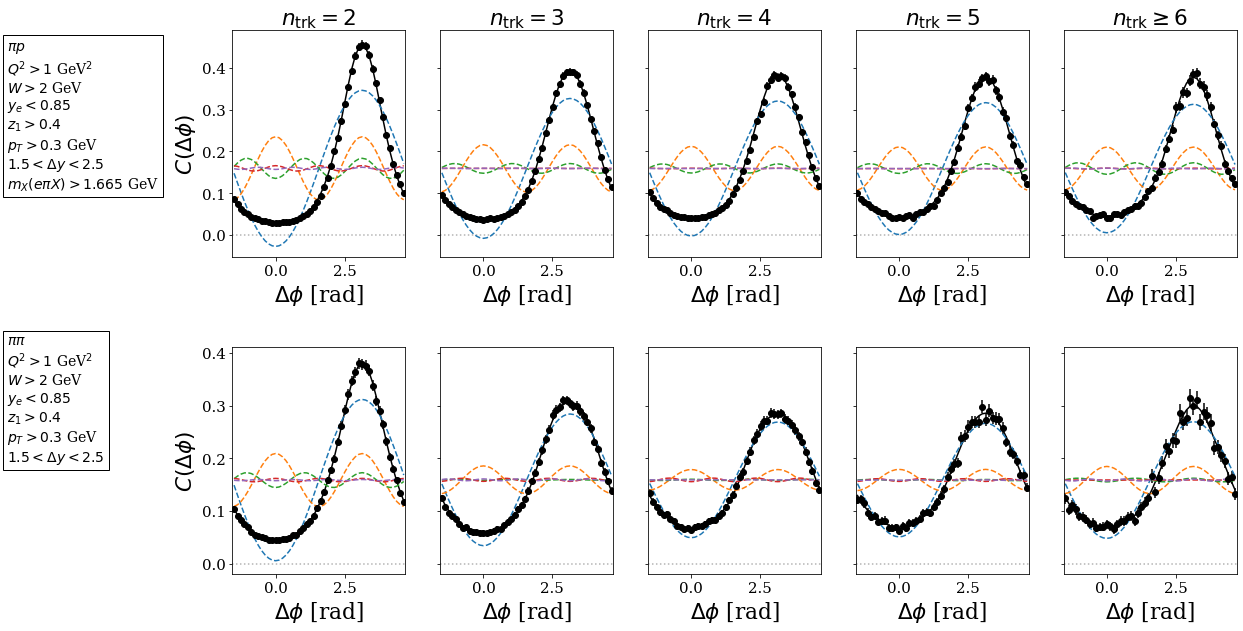

In [140]:


gc.collect()
fig,axs = plt.subplots(2,5, figsize=(18,10),sharey='row')
fig.subplots_adjust(hspace=0.4)

axs[0][0].text(-1.3,0.3,"$\pi p$\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$y_e<0.85$\n$z_{1}>0.4$\n$p_T>0.3$ GeV\n$1.5<\Delta y<2.5$\n$m_X(e\pi X)>1.665$ GeV",
               bbox=dict(facecolor='white', alpha=1),transform=axs[0][0].transAxes,fontsize=14)
#axs[1][0].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.5$\n$1.5<\Delta y<2.5$",loc='upper left'))
axs[1][0].text(-1.3,0.5,"$\pi\pi$\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$y_e<0.85$\n$z_{1}>0.4$\n$p_T>0.3$ GeV\n$1.5<\Delta y<2.5$",
               bbox=dict(facecolor='white', alpha=1),transform=axs[1][0].transAxes,fontsize=14)
for ax in axs[0][0],axs[1][0]:
    ax.set_ylabel("$C(\\Delta\\phi)$")


for q,label,ax1,ax2 in zip(["nhtracks == 2","nhtracks == 3","nhtracks == 4","nhtracks == 5","nhtracks>=6"],
                   ['$n_{\\mathrm{trk}}' + k +"$" for k in '=2;=3;=4;=5;\\geq 6'.split(';')],
                   axs[0],axs[1]):
    ax1.set_title(label)
    plt.sca(ax1)
    x,yi,dyi = corr1d(pi_p_mXcut_inb.query(q),pi_p_mXcut_mc_inb,deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    x,yo,dyo = corr1d(pi_p_mXcut_outb.query(q),pi_p_mXcut_mc_outb,deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    yc = (yo/dyo**2+yi/dyi**2)/(1/dyo**2+1/dyi**2)
    dyc = np.sqrt(1/(1/dyo**2+1/dyi**2))
    print(ridge_yield(x,yc,dyc))
    plot1d(x,yc,dyc,plt.gca())
    #area = sum(y)*(x[1]-x[0])
    #corr1d(pi_p_mXcut_mc.query(q),pi_p_mXcut_mixed_mc.query(q),deta_range=(-1.5,2.5),bins=20,area=area,
    #                      fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False,style='fill')
    #ax2.set_title(label + ",   $\pi\pi$")
    plt.sca(ax2)
    x,yi,dyi = corr1d(pi_pi_inb.query(q),pi_pi_mc_inb,deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    x,yo,dyo = corr1d(pi_pi_outb.query(q),pi_pi_mc_outb,deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    yc = (yo/dyo**2+yi/dyi**2)/(1/dyo**2+1/dyi**2)
    dyc = np.sqrt(1/(1/dyo**2+1/dyi**2))
    print(ridge_yield(x,yc,dyc)[:-1])
    plot1d(x,yc,dyc,plt.gca())
    #area = sum(y)*(x[1]-x[0])
    #x,y,dy = corr1d(pi_pi_mc.query(q),pi_pi_mixed_mc.query(q),deta_range=(-1.5,2.5),bins=20,area=area,
    #                      fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False,style='fill')
    #print("x,y,dy = ", x,y,dy)
plt.savefig("../images/corrs_vs_ntracks_mc.pdf",bbox_inches='tight')

In [8]:
#print crap
print("ymc,xmc = [],[]")
for qq in ["nhtracks == 2","nhtracks == 3","nhtracks == 4","nhtracks == 5","nhtracks>=6"]:
    q = qq 
    q += " and diff_rap_cm_truth > %s and diff_rap_cm_truth < %s" % (1.5,2.5)
    for part in "e h1 h2".split():
        q += " and part_truth_th < 45*3.14159/180 and part_truth_th > 5*3.14159/180".replace("part",part)
    for df in pi_p_mXcut_mc_inb, pi_pi_mc_inb:
        
        y,x = np.histogram(offset(df.query(q).diff_phi_cm_truth),bins=24, range=(-np.pi/2,3*np.pi/2))
        y = pd.Series(y)/(np.sum(y)*(x[1]-x[0]))
        x = (pd.Series(x[1:])+x[:-1])/2
        print("ymc.append(",list(y),")")
        print("xmc.append(",list(x),")")
        

ymc,xmc = [],[]
ymc.append( [0.0958431234041084, 0.06637986678353437, 0.05257365485267115, 0.043919761142383704, 0.04076834320164319, 0.03641638509300152, 0.03681656514896857, 0.04066829818765142, 0.04457005373333016, 0.05757590555225927, 0.07308288272098244, 0.09164123281645438, 0.12695712275554652, 0.168025600999165, 0.22800258688722655, 0.3018858297201431, 0.3590115327094394, 0.3881246317810423, 0.3964283679423586, 0.36216295065017995, 0.2935820935588268, 0.22485116894648605, 0.16457404801644918, 0.12585662760163713] )
xmc.append( [-1.439896632895322, -1.1780972450961724, -0.9162978572970231, -0.6544984694978736, -0.39269908169872425, -0.1308996938995748, 0.13089969389957468, 0.39269908169872403, 0.6544984694978735, 0.9162978572970228, 1.1780972450961722, 1.4398966328953218, 1.7016960206944711, 1.9634954084936205, 2.22529479629277, 2.4870941840919194, 2.7488935718910685, 3.010692959690218, 3.2724923474893677, 3.534291735288517, 3.7960911230876664, 4.057890510886816, 4.31968989868596

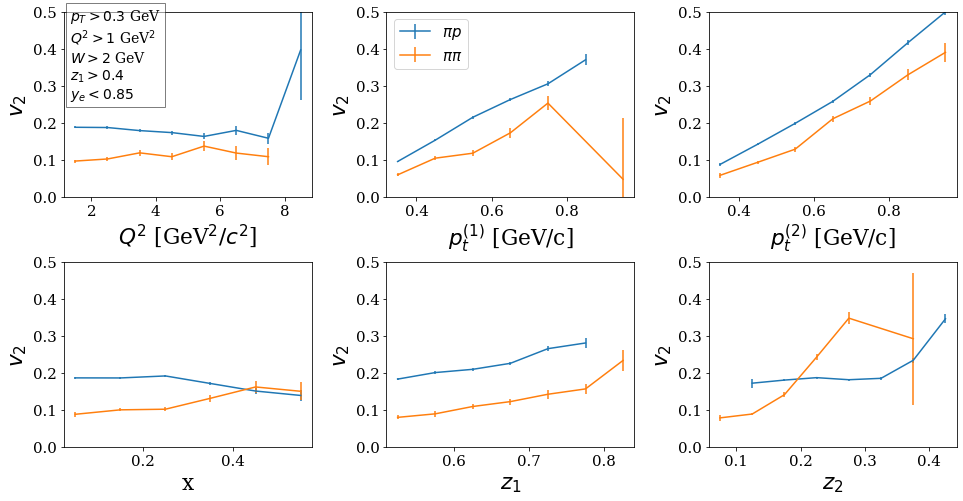

In [74]:
#v2 plots for presentation
dfs = [[pi_p_mXcut_inb,pi_p_mXcut_outb],[pi_pi_inb,pi_pi_outb]]
dfs_mixed = [[pi_p_mXcut_mc_inb,pi_p_mXcut_mc_outb], [pi_pi_mc_inb, pi_pi_mc_outb]]
labels = '$\pi p$;$\pi\pi$'.split(";")
#for q in "h2_pid == 2212 and abs(h1_pid) == 211","abs(h2_pid) == 211 and abs(h1_pid) == 211":
#    dfs.append(data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
#                             + " and " + q))
#    
#    dfs_mixed.append(mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
#                             + " and " + q))

fig, axs = plt.subplots(2,3, figsize=(16,8))    
fig.subplots_adjust(hspace=0.35,wspace=0.3)

plt.sca(axs[1][1])    
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h1_z', 0.5, 1, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$z_1$")


plt.sca(axs[1][2]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h2_z', 0, 0.5, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$z_2$")


plt.sca(axs[0][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h1_cm_pt', 0, 1, 10,label=label)
plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$p_t^{(1)}$ [GeV/c]")


plt.sca(axs[0][2]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h2_cm_pt', 0, 1, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$p_t^{(2)}$ [GeV/c]")


plt.sca(axs[1][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'x', 0, 1, 10,label=label)
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("x")

plt.sca(axs[0][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'Q2', 1, 10, 9,label=label)
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$Q^2$ [GeV$^2/c^2$]")

for a in axs:
    for b in a:
        b.set_ylim(0,0.5)
        
fig.text(0.13,0.73,"$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_1>0.4$\n$y_e<0.85$",bbox=dict(facecolor='white', alpha=0.5),fontsize=14)
plt.savefig("../images/v2_vs_stuff1.pdf",bbox_inches='tight')

In [ ]:
mixed.columns

In [ ]:
#v2 plots for presentation
dfs = [pi_p_mXcut,pi_pi]
dfs_mixed = [pi_p_mXcut_mixed, pi_pi_mixed]
labels = '$\pi p$;$\pi\pi$'.split(";")
#for q in "h2_pid == 2212 and abs(h1_pid) == 211","abs(h2_pid) == 211 and abs(h1_pid) == 211":
#    dfs.append(data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
#                             + " and " + q))
#    
#    dfs_mixed.append(mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
#                             + " and " + q))

fig, axs = plt.subplots(2,3, figsize=(16,8))    
fig.subplots_adjust(hspace=0.35,wspace=0.3)

plt.sca(axs[0][0])    
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h1_z', 0.5, 1, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$z_1$")


plt.sca(axs[1][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h2_z', 0, 0.5, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$z_2$")


plt.sca(axs[0][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h1_cm_pt', 0, 1, 10,label=label)
plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$p_t^{(1)}$ [GeV/c]")


plt.sca(axs[1][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h2_cm_pt', 0, 1, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$p_t^{(2)}$ [GeV/c]")


plt.sca(axs[1][2]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'x', 0, 1, 10,label=label)
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("x")

plt.sca(axs[0][2]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'Q2', 1, 10, 9,label=label)
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$Q^2$ [GeV$^2/c^2$]")

for a in axs:
    for b in a:
        b.set_ylim(0,0.5)
        
fig.text(0.13,0.73,"$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_1>0.4$\n$y_e<0.85$",bbox=dict(facecolor='white', alpha=0.5),fontsize=14)
plt.savefig("../images/v2_vs_stuff1.pdf",bbox_inches='tight')

In [ ]:
dfs = []
dfs_mixed = []
labels = '$\pi p$;$\pi^+ p$;$\pi^- p$;$\pi\pi$'.split(";")
for q in "h2_pid == 2212 and abs(h1_pid) == 211","h2_pid == 2212 and h1_pid == 211","h2_pid == 2212 and h1_pid == -211","abs(h2_pid) == 211 and abs(h1_pid) == 211":
    dfs.append(data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                             + " and " + q))
    
    dfs_mixed.append(mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                             + " and " + q))

fig, axs = plt.subplots(2,2, figsize=(12,8))    
fig.subplots_adjust(hspace=0.3)

plt.sca(axs[0][0])    
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h1_z', 0.5, 1, 10,label=label)
plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$z_1$")


plt.sca(axs[0][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h2_z', 0, 0.5, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$z_2$")


plt.sca(axs[1][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h1_cm_pt', 0, 1, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$p_t^{(1)}$ [GeV/c]")


plt.sca(axs[1][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'h2_cm_pt', 0, 1, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$p_t^{(2)}$ [GeV/c]")

for a in axs:
    for b in a:
        b.set_ylim(0,1.2)
plt.savefig("../images/v2_vs_stuff2.pdf")

fig, axs = plt.subplots(2,2, figsize=(12,8))      
fig.subplots_adjust(hspace=0.3)  
plt.sca(axs[0][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'x', 0, 1, 10,label=label)
plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("x")



plt.sca(axs[0][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'W', 2, 4, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$W$ [GeV$/c^2$]")

plt.sca(axs[1][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'Q2', 1, 10, 9,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$Q^2$ [GeV$^2/c^2$]")

plt.sca(axs[1][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'mx_eh1x', 1, 3.5, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$m_X(eh_1 X)$")


for a in axs:
    for b in a:
        b.set_ylim(0,1.2)
plt.savefig("../images/v2_vs_stuff2.pdf")
plt.show()


fig, axs = plt.subplots(2,2, figsize=(12,8))    
fig.subplots_adjust(hspace=0.3)    
plt.sca(axs[0][0]) 

for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'nhtracks', 1.5, 7.5, 6,label=label)
plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("# of hadron tracks")


plt.sca(axs[0][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'pair_mass', 0, 6, 20,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("pair mass [GeV$/c^2$]")

plt.sca(axs[1][0]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'diff_rap_cm', 1.5, 2.5, 10,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$\Delta y$")


plt.sca(axs[1][1]) 
for df,df_mixed,label in zip(dfs,dfs_mixed,labels):
    v2_plot(df,df_mixed, 'mx_eh1h2x', 0, 6, 20,label=label)
#plt.legend()
plt.gca().set_ylabel("$v_2$")
plt.gca().set_xlabel("$m_X(eh_1h_2 X)$ [GeV$/c^2$]")


for a in axs:
    for b in a:
        b.set_ylim(0,1.2)
plt.savefig("../images/v2_vs_stuff3.pdf")
plt.show()

In [ ]:
import scipy.optimize,numpy.random,time,os
def upper_limit_yridge(df,df_mixed,n=3,bins = 100,miniterations=100,maxiterations=200000,fitrange=(0,np.pi),
                       progressPrintInterval=None, #print stats after every [...] iterations (don't print if 0)
                       sayDone=False,projyrange=(1.5,2.5)):
    if len(df) == 0:
        return 1, 1.0, 0,0,[]
    start = time.perf_counter()
    import scipy.optimize
    #radius = 0.3
    #M00 = len(df_mixed.query('sqrt(diff_rap_cm**2+diff_phi_cm**2)<%s'%radius))/(np.pi*radius**2)
    
    denom = 2*np.pi/bins
    ys, x = np.histogram(np.abs(df.query("diff_rap_cm > %s and diff_rap_cm < %s" %projyrange).diff_phi_cm), bins=bins, range=(0,np.pi))
    x = np.add(x[1:],x[:-1])/2
    dys = np.sqrt(ys)
    ys=np.divide(ys,denom)
    dys=np.divide(dys,denom)
    
    
    mixed_highy = df_mixed.query("diff_rap_cm > %s and diff_rap_cm < %s" %projyrange)
    denom = 1#M00*2*np.pi/bins
    ym, _ = np.histogram(np.abs(mixed_highy.diff_phi_cm), bins=bins, range=(0,np.pi))
    dym = np.sqrt(ym)
    ym=np.divide(ym,denom)
    dym=np.divide(dym,denom)
    
    dyc = ys/(ym+.0001)*np.hypot(dys/(ys+0.0001), dym/(ym+0.0001))
    dyc = dyc*(dyc<1) + (dyc>=1)
    yc= ys/(ym+.0001)
    
    x = pd.Series(x)
    y = pd.Series(yc)
    dy = pd.Series(dyc)
    w = 1/dy**2
    yields=[]
    nonzeroyields=0
    for ii in range(maxiterations):
        yrand = y+numpy.random.randn(len(dy))*dy*(dy<999)
        #print((yrand-y)/dy)
        if n==3:
            def f (xx,b0,b1,b2,b3):
                args=[b0,b1,b2,b3]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        
        if n==4:
            def f (xx,b0,b1,b2,b3,b4):
                args=[b0,b1,b2,b3,b4]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        if n==5:
            def f (xx,b0,b1,b2,b3,b4,b5):
                args=[b0,b1,b2,b3,b4,b5]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        b,bcov = scipy.optimize.curve_fit(f, x, yrand,sigma=1/np.sqrt(w))
        
        #don't waste your time if f''[0] is positive
        fpp0= sum([-i*i*b[i] for i in range(len(b))])
        #print(fpp0)
        if fpp0 < 0:  
            s = 0
            for i in range(0,n+1):
                s = b[i]*np.cos(i*x)+s

            smin = max(s)

            xmin=fitrange[0]
            for xi,si in zip(x,s):
                if(xi<fitrange[0]):
                    continue
                if(si<smin):
                    xmin = xi
                    smin = si
            integral = 0
            dx = x[1]-x[0]
            for xi,yi in zip(x,yrand):
                if(xi<xmin):
                    integral+=(yi-smin)*dx
                else:
                    break
            yeild = integral
            yeild /= sum(y)*dx
            yields.append(yeild)
            nonzeroyields+=1
        else :
            yields.append(0)
        durationsofar = time.perf_counter()-start;
        if progressPrintInterval:
            if ii%progressPrintInterval == 0:
                print("iter ", ii, "; average so far: ", durationsofar/(ii+1), 
                    ";   time so far: ",durationsofar//3600,"hours", (durationsofar//60)%60, "minutes", int(durationsofar % 60), "seconds")
        if ii == miniterations and nonzeroyields == 0:
            break
            
    duration = time.perf_counter()-start;
    print("total time: ",int(duration//3600),"hours", int((duration//60)%60), "minutes", int(duration % 60), "seconds")
    if sayDone:
        os.system('say "done"')    
    yields = pd.Series(yields)
    
    UL = yields.quantile(.95)
    CL = .95
    median = yields.median()
    LL = yields.quantile(.05)
    
    thresh = 1e-5
    if UL <thresh:
        UL = thresh
        CL = len(yields[yields<thresh])/len(yields)
        median = 0
        LL = 0
    return UL, CL,median,LL,yields

In [ ]:
def exclusion_plot(df,df_mixed,expr, mn=None,mx=None,bins=None,partitions=None,showMedians=True,showLL=True,alpha=1,
                   offset=0,label='',fillstyle='full',color=None, miniterations=1000, plotYields=False):
    
    #for pid,pm,shift,color in (211,"+",-offset/2,'r'),(-211,'-',offset/2,'k'):
    x,ul,cl,medians,ll=[],[],[],[],[]
    if mn != None and mx != None and bins != None:
        mins = [mn +i*(mx-mn)/bins for i in range(bins)]
        maxs = [mn +(i+1)*(mx-mn)/bins for i in range(bins)]
        shift = offset*(mx-mn)/bins
    elif partitions != None:
        mins = partitions[:-1]
        maxs = partitions[1:]
        shift = offset
    else:
        print("either use the partitions argument or the mn, mx and bins arguments")
    allYields = []
    import multiprocessing
    manager = multiprocessing.Manager()
    x = manager.list([0]*len(mins))
    ul = manager.list([0]*len(mins))
    cl = manager.list([0]*len(mins))
    ll = manager.list([0]*len(mins))
    medians = manager.list([0]*len(mins))
    allYields = manager.list([[]]*len(mins))
    def f(mni,mxi,i,lock=None,):
        q = "%s >= %s and %s < %s" %(expr, mni, expr, mxi)
        dfbin = df.query(q)
        dfbin_mix = df_mixed.query(q)
        a = upper_limit_yridge(dfbin,dfbin_mix,miniterations=miniterations,maxiterations=miniterations,n=3,bins=50,fitrange=(0,np.pi))
        if len(a) != 5:
            print(a)
        UL,CL,median,LL,yields =a
        if UL > 1:
            return
        xmean = np.mean(dfbin.eval(expr))+shift
        print(xmean,UL,CL,median,LL,len(dfbin),len(dfbin_mix))
        
        #avoid allowing more than one thread to append these values simultaneously
        if lock!= None:
            lock.acquire()
        try:
            x[i] = xmean
            ul[i] = UL
            cl[i] = CL
            medians[i] = median
            ll[i] = LL
            allYields[i] = yields
            print("x is ",x)
        finally:
            if lock != None:
                lock.release()
    processes = []
    lock = multiprocessing.Lock()
    for i,(mni, mxi) in enumerate(zip(mins,maxs)):
        p = multiprocessing.Process(target=f, args=(mni, mxi,i,lock))
        processes.append(p)
        p.start()
    for process in processes:
        process.join()
    print("x is " + str(x))
    x = pd.Series([x[i] for i in range(len(x))])
    y =  pd.Series([medians[i] for i in range(len(x))])
    ylo =  pd.Series([ll[i] for i in range(len(x))])
    yup =  pd.Series([ul[i] for i in range(len(x))])
    
    if not plotYields:
        ret = plt.errorbar(x,y*(ylo >1e-5)+yup*(ylo<=1e-5),[(y-ylo)*(ylo >=1e-5)+(yup*.9)*(ylo<=1e-5),yup-y],
                 label=label,linestyle='',fillstyle='none', color=color,
                 uplims=(ylo<=1e-5),capsize=10,elinewidth=2,markeredgewidth=2)
        plt.plot(x,y-1*(ylo<=1e-5), linestyle='',marker='o',fillstyle='full',color=color,markersize=10)


        plt.gca().set_yscale('log')
        for i in range(len(x)):
            plt.text(x[i],ul[i],'%s%%'%int(100*cl[i]) if cl[i]!= 1 else ">99%",fontsize=12,ha='center')
        plt.grid(color='0.5',alpha=0.5)
        plt.gca().set_ylabel("Ridge yield")
        plt.axhline(1,linestyle=':',color='0.5',alpha=0.7)
        return ret
    else :
        for yields in allYields:
            plt.hist(yields,bins=40,histtype='step')
            plt.show()
        

In [ ]:
import gc
gc.collect()

In [ ]:
# money plot!!!!
handles = []
from matplotlib.ticker import FormatStrFormatter
fig,ax = plt.subplots(1,1, figsize=(14,10))  
ax.set_xlabel("# of tracks")
plt.grid(color='0.5',alpha=0.5)
plt.gca().set_ylabel("Ridge yield")
plt.axhline(1,linestyle=':',color='0.5',alpha=0.7)

#ALEPH
x = [9, 16, 23, 33, 37]
y = [1.21e-3, 1e-5, 5.38e-5, 2.31e-3,8.58e-3]
handles.append(plt.errorbar(x,y,pd.Series(y)*.9,label='ALEPH@LEP',linestyle='',alpha=0.3,
             fillstyle='none', color='tab:green',uplims=True,capsize=10,elinewidth=2,markeredgewidth=2))
ax.set_xscale('log')
ax.set_yscale('log')

#HERA
x = 2.471264367816093,4.42528735632184,6.379310344827587,8.390804597701148,\
        10.344827586206897,12.643678160919539,15.919540229885055
y = 0.0009411764705882342, 0.0009411764705882342, 0.0025882352941176467, 0.0021176470588235297,\
        0.005411764705882355, 0.0051764705882352935, 0.026823529411764707
handles.append(plt.errorbar(x,y,pd.Series(y)*.9,label='H1@HERA (prelim.)',linestyle='',alpha=0.3,
             fillstyle='none', color='tab:red',uplims=True,capsize=10,elinewidth=2,markeredgewidth=2))

#CMS pPb
x = pd.Series([5.596330,11.926606,20.366972,28.715596,37.155963,45.504587])
y = pd.Series([0.001767,0.001134,0.001134,0.002133,0.003739,0.008104])
yup = pd.Series([0.004765, 0.003543, 0.004058, 0.005551, 0.006590, 0.011549])
ylo = pd.Series([0,0,0,0,0.000220,0.004598])


handles.append(plt.errorbar(x,y*(ylo !=0)+yup*(ylo==0),[(y-ylo)*(ylo !=0)+(yup*.9)*(ylo == 0),yup-y],
             label='CMS $p$Pb',linestyle='',alpha=0.5,fillstyle='none', color='tab:purple',
             uplims=(ylo==0),capsize=10,elinewidth=2,markeredgewidth=2))
plt.plot(x,y*(ylo>1e-5), linestyle='',marker='o',fillstyle='full',color='tab:purple',alpha=0.3,markersize=10)




#CMS PbPb
x = pd.Series([5.688073,11.743119,20.275229,28.623853,37.155963,45.504587,])
y = pd.Series([0.003007,0.000921,0.000621, 0.002457, 0.007074, 0.014799])
yup = pd.Series([0.006108, 0.004079, 0.003522, 0.005549, 0.009731, 0.018969])
ylo = pd.Series([0,0,0,0,0.004791,0.010026])

#shift for visual clarity
x = np.multiply(x,1.05)
#plt.errorbar(np.multiply(x,1.05),y,[np.subtract(y,ylo),np.subtract(yup,y)],label='CMS Pb Pb',linestyle='-',alpha=0.5,fillstyle='none', color='tab:brown')
handles.append(plt.errorbar(x,y*(ylo !=0)+yup*(ylo==0),[(y-ylo)*(ylo !=0)+(yup*.9)*(ylo == 0),yup-y],
             label='CMS PbPb',linestyle='',alpha=0.5,fillstyle='none', color='tab:brown',
             uplims=(ylo==0),capsize=10,elinewidth=2,markeredgewidth=2))
plt.plot(x,y*(ylo>1e-5), linestyle='',marker='o',fillstyle='full',color='tab:brown',alpha=0.3,markersize=10)


#38.348624, 0.001785
#38.348624, 0.002543
#38.348624, 0.001012
handles.append(plt.errorbar([38.348624],[0.001785], [[0.001785-0.001012],[0.002543-0.001785]],label='CMS $pp$',linestyle='',alpha=0.3,fillstyle='full', color='black',
             capsize=10,elinewidth=2,markeredgewidth=2))
plt.plot([38.348624],[0.001785],linestyle='',alpha=0.3,fillstyle='full', color='black',marker='o',markersize=10)


plt.tick_params(axis='x', which='minor')
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
plt.legend(loc='upper right',ncol=2)
plt.gca().set_xlim(1.5,57)
plt.savefig("../images/moneyplot_noCLAS12.pdf",bbox_inches='tight')


handles.append(exclusion_plot(pi_p_mXcut,pi_p_mXcut_mixed, "nhtracks",partitions=[1.5,2.5, 3.5, 4.5, 5.5, 13.5],offset=-0.1,label='CLAS12: $\pi p$ (prelim.)',color='tab:blue'))
 

handles.append(exclusion_plot(pi_pi,pi_pi_mixed, "nhtracks",partitions=[1.5,2.5,3.5, 4.5, 5.5, 13.5],offset=0.1, label='CLAS12: $\pi\pi$ (prelim.)',color='tab:orange'))


plt.legend(loc='upper right', handles = [handles[i] for i in [5,6,0,1,2,3,4]], ncol=2)
plt.savefig("../images/moneyplot.pdf",bbox_inches='tight')



In [ ]:
fig,axs = plt.subplots(2,5, figsize=(18,10))
fig.subplots_adjust(hspace=0.4)

axs[0][0].text(0,0.5,"$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.4$\n$1.5<\Delta y<2.5$\n$m_X(e\pi X)>1.665$ GeV",
               bbox=dict(facecolor='white', alpha=0.5),transform=axs[0][0].transAxes,fontsize=12)
#axs[1][0].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.5$\n$1.5<\Delta y<2.5$",loc='upper left'))
axs[1][0].text(0,0.5,"$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.4$\n$1.5<\Delta y<2.5$",
               bbox=dict(facecolor='white', alpha=0.5),transform=axs[1][0].transAxes,fontsize=12)

for q,label,ax1,ax2 in zip(["nhtracks == 2","nhtracks == 3","nhtracks == 4","nhtracks == 5", "nhtracks >=6"],
                   ['$n_{\\mathrm{trk}}' + k +"$" for k in '=2 =3 =4 =5 >=6'.split()],
                   axs[0],axs[1]):
    ax1.set_title(label)
    plt.sca(ax1)
    x,y,dy = corr1d(pi_p_mXcut.query(q),pi_p_mXcut_mixed.query(q),deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    #area = sum(y)*(x[1]-x[0])
    #corr1d(pi_p_mXcut_mc.query(q),pi_p_mXcut_mixed_mc.query(q),deta_range=(-1.5,2.5),bins=20,area=area,
    #                      fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False,style='fill')
    #ax2.set_title(label + ",   $\pi\pi$")
    plt.sca(ax2)
    x,y,dy = corr1d(pi_pi.query(q),pi_pi_mixed.query(q),deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    #area = sum(y)*(x[1]-x[0])
    #x,y,dy = corr1d(pi_pi_mc.query(q),pi_pi_mixed_mc.query(q),deta_range=(-1.5,2.5),bins=20,area=area,
    #                      fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False,style='fill')
    #print("x,y,dy = ", x,y,dy)
plt.savefig("../images/corrs_vs_ntracks.pdf",bbox_inches='tight')

In [ ]:
fig,axs = plt.subplots(2,5, figsize=(18,10))
fig.subplots_adjust(hspace=0.4)

axs[0][0].text(0,0.5,"$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.4$\n$1.5<\Delta y<2.5$\n$m_X(e\pi X)>1.665$ GeV",
               bbox=dict(facecolor='white', alpha=0.5),transform=axs[0][0].transAxes,fontsize=12)
#axs[1][0].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.5$\n$1.5<\Delta y<2.5$",loc='upper left'))
axs[1][0].text(0,0.5,"$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.4$\n$1.5<\Delta y<2.5$",
               bbox=dict(facecolor='white', alpha=0.5),transform=axs[1][0].transAxes,fontsize=12)

for q,label,ax1,ax2 in zip(["nhtracks == 2","nhtracks == 3","nhtracks == 4","nhtracks == 5", "nhtracks >=6"],
                   ['$n_{\\mathrm{trk}}' + k +"$" for k in '=2 =3 =4 =5 >=6'.split()],
                   axs[0],axs[1]):
    ax1.set_title(label)
    plt.sca(ax1)
    x,y,dy = corr1d(pi_p_mXcut.query(q),pi_p_mXcut_mixed.query(q),deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    area = sum(y)*(x[1]-x[0])
    corr1d(pi_p_mXcut_mc.query(q),pi_p_mXcut_mixed_mc.query(q),deta_range=(-1.5,2.5),bins=20,area=area,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False,style='fill')
    ax2.set_title(label + ",   $\pi\pi$")
    plt.sca(ax2)
    x,y,dy = corr1d(pi_pi.query(q),pi_pi_mixed.query(q),deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    area = sum(y)*(x[1]-x[0])
    x,y,dy = corr1d(pi_pi_mc.query(q),pi_pi_mixed_mc.query(q),deta_range=(-1.5,2.5),bins=20,area=area,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False,style='fill')
    print("x,y,dy = ", x,y,dy)
plt.savefig("../images/corrs_vs_ntracks_with_mc.pdf",bbox_inches='tight')

In [ ]:
fig,axs = plt.subplots(2,4, figsize=(18,10))
fig.subplots_adjust(hspace=0.3)
axs[0][0].text(0,0.5,"$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.5$\n$1.5<\Delta y<2.5$\n$m_X(e\pi X)>1.665$ GeV",
               bbox=dict(facecolor='white', alpha=0.5),transform=axs[0][0].transAxes,fontsize=12)
#axs[1][0].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.5$\n$1.5<\Delta y<2.5$",loc='upper left'))
axs[1][0].text(0,0.5,"$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.5$\n$1.5<\Delta y<2.5$",
               bbox=dict(facecolor='white', alpha=0.5),transform=axs[1][0].transAxes,fontsize=12)

for q,label,ax1,ax2 in zip(["0<=h2_z and h2_z <.1","0.1<=h2_z and h2_z <0.2","0.2<=h2_z and h2_z <0.3","0.3<=h2_z and h2_z <0.5"],
                   "$0\leq{}z_2<0.1$ $0.1\leq{}z_2<0.2$ $0.2\leq{}z_2<0.3$ $0.3\leq{}z_2<0.5$".split(),
                   axs[0],axs[1]):
    ax1.set_title(label + ",   $\pi p$")
    plt.sca(ax1)
    corr1d(pi_p_mXcut.query(q),pi_p_mXcut_mixed.query(q),deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
    
    ax2.set_title(label + ",   $\pi\pi$")
    plt.sca(ax2)
    corr1d(pi_pi.query(q),pi_pi_mixed.query(q),deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=False)
plt.savefig("../images/corrs_vs_z2.pdf",bbox_inches='tight')

In [ ]:
for i, (q,label) in enumerate(zip(["0<=h2_z and h2_z <.1","0.1<=h2_z and h2_z <0.2","0.2<=h2_z and h2_z <0.3","0.3<=h2_z and h2_z <0.5"],
                   "$0\leq{}z_2<0.1$ $0.1\leq{}z_2<0.2$ $0.2\leq{}z_2<0.3$ $0.3\leq{}z_2<0.5$".split(),
                   )):
    
    dphi_deta_plot_3_proj(pi_p_mXcut.query(q),pi_p_mXcut_mixed.query(q),
                          text="$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.5$\n$1.5<\Delta y<2.5$\n$m_X(e\pi X)>1.665$ GeV\n" + label)
    plt.savefig("../images/smc_vs_z2_pi_p_bin%s.pdf" %i,bbox_inches='tight')
    plt.show()
    dphi_deta_plot_3_proj(pi_pi.query(q),pi_pi_mixed.query(q),
                          text = "$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{1}>0.5$\n$1.5<\Delta y<2.5$\n" + label)
    plt.savefig("../images/smc_vs_z2_pi_pi_bin%s.pdf" % i,bbox_inches='tight')
    plt.show()

In [ ]:
#check yields:

exclusion_plot(pi_p,pi_p_mixed, "nhtracks",partitions=[1.5,2.5, 3.5, 4.5, 10.5],
               label='CLAS12:  $\pi p$',color='tab:blue',plotYields=True)

exclusion_plot(pi_pi,pi_pi_mixed, "nhtracks",partitions=[1.5,2.5,3.5, 4.5, 10.5], 
               label='CLAS12:  $\pi\pi$',color='tab:orange',plotYields=True)



NameError: name 'exclusion_plot' is not defined

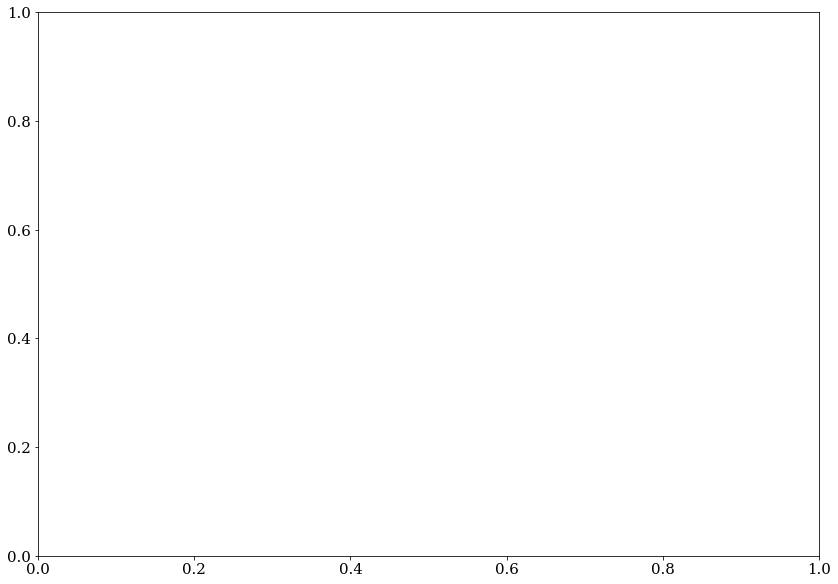

In [12]:
# money plot!!!! (old version)

from matplotlib.ticker import FormatStrFormatter
fig,ax = plt.subplots(1,1, figsize=(14,10))  
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212")
nbins = 7
exclusion_plot(df,df_mixed, "nhtracks",partitions=[1.5,2.5, 3.5, 4.5, 10.5],offset=-0.1,label='CLAS12:  $\pi p$',color='tab:blue')
 
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and abs(h2_pid) == 211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and abs(h2_pid) == 211")
nbins = 7
exclusion_plot(df,df_mixed, "nhtracks",partitions=[1.5,2.5,3.5, 4.5, 10.5],offset=0.1, label='CLAS12:  $\pi\pi$',color='tab:orange')
ax.set_xlabel("# of tracks")

x = [9, 16, 23, 33, 37]
y = [1.21e-3, 1e-5, 5.38e-5, 2.31e-3,8.58e-3]
plt.errorbar(x,[0]*len(y),[[0]*len(y),y],label='ALEPH@LEP',linestyle='-',alpha=0.5,fillstyle='none', color='tab:green')
ax.set_xscale('log')


x = 2.471264367816093,4.42528735632184,6.379310344827587,8.390804597701148,\
        10.344827586206897,12.643678160919539,15.919540229885055
y = 0.0009411764705882342, 0.0009411764705882342, 0.0025882352941176467, 0.0021176470588235297,\
        0.005411764705882355, 0.0051764705882352935, 0.026823529411764707
plt.errorbar(x,[0]*len(y),[[0]*len(y),y],label='H1@HERA (preliminary)',linestyle='-',alpha=0.5,fillstyle='none', color='tab:red')

#CMS pPb
x = 5.596330,11.926606,20.366972,28.715596,37.155963,45.504587
y = 0.001767,0.001134,0.001134,0.002133,0.003739,0.008104
yup = 0.004765, 0.003543, 0.004058, 0.005551, 0.006590, 0.011549
ylo = 0,0,0,0,0.000220,0.004598
plt.errorbar(x,y,[np.subtract(y,ylo),np.subtract(yup,y)],label='CMS pPb',linestyle='-',alpha=0.5,fillstyle='none', color='tab:purple')





#CMS PbPb
x = 5.688073,11.743119,20.275229,28.623853,37.155963,45.504587,
y = 0.003007,0.000921,0.000621, 0.002457, 0.007074, 0.014799
yup = 0.006108, 0.004079, 0.003522, 0.005549, 0.009731, 0.018969
ylo = 0,0,0,0,0.004791,0.010026

plt.errorbar(np.multiply(x,1.05),y,[np.subtract(y,ylo),np.subtract(yup,y)],label='CMS PbPb',linestyle='-',alpha=0.5,fillstyle='none', color='tab:brown')





plt.tick_params(axis='x', which='minor')
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
plt.legend(loc='upper left')
plt.savefig("../images/moneyplot.pdf")


In [ ]:
# money plot 2!!!!

fig,ax = plt.subplots(1,1, figsize=(14,10))  
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and h1_pid==211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and h1_pid==211")
nbins = 4
exclusion_plot(df,df_mixed, "nhtracks",1.5,1.5+nbins,nbins,offset=-0.2,label='CLAS12:  $\pi^+ p$')

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and h1_pid==-211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and h1_pid==-211")
nbins = 3
exclusion_plot(df,df_mixed, "nhtracks",1.5,1.5+nbins,nbins,offset=-0.1,label='CLAS12:  $\pi^- p$')
    
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 211 and h1_pid == 211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 211 and h1_pid == 211")
nbins = 3
exclusion_plot(df,df_mixed, "nhtracks",1.5,1.5+nbins,nbins,offset=0.0, label='CLAS12:  $\pi^+\pi^+$')
ax.set_xlabel("# of tracks")

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 211 and h1_pid == -211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 211 and h1_pid == -211")
nbins = 3
exclusion_plot(df,df_mixed, "nhtracks",1.5,1.5+nbins,nbins,offset=0.1, label='CLAS12:  $\pi^-\pi^+$')
ax.set_xlabel("# of tracks")

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == -211 and h1_pid == 211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == -211 and h1_pid == 211")
nbins = 4
exclusion_plot(df,df_mixed, "nhtracks",1.5,1.5+nbins,nbins,offset=0.2, label='CLAS12:  $\pi^+\pi^-$')
ax.set_xlabel("# of tracks")


plt.legend()
plt.savefig("../images/moneyplot_2.pdf")

In [ ]:
#pi pi (either charge) 3 <=ntracks <=4
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211 and nhtracks >=3 and nhtracks<=4 and mx_eh1x >1.665")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211 and abs(h1_pid) == 211 and nhtracks >=3 and nhtracks<=4 and mx_eh1x >1.665")
#df_trig = data_triggers.query("h_cm_pt>0.3 and abs(h_pid) == 211")
fig,axs = dphi_deta_plot_3_proj(df,df_mixed,
              deta_range=(-0.5,2.5))
axs[0].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{\\pi1}>0.5$\nntracks=3 or 4",loc='upper left'))
plt.savefig("../images/smc_pi_pi_3to4.pdf",bbox_inches='tight')
plt.show()



#df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
#                         + "and h2_pid == 2212")
#df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
#                         + "and h2_pid == 211 and abs(h1_pid) == 211 and nhtracks >=3 and nhtracks<=4")
#df_trig = data_triggers.query("h_cm_pt>0.3 and abs(h_pid) == 211")
#fig,axs = dphi_deta_plot_3_proj(df,df_mixed,df_trig,
#              deta_range=(-0.5,2.5))
#axs[0].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{\\pi1}>0.5$\nntracks=3 or 4",loc='upper left'))
#plt.savefig("../images/smc_pi_pi_3to4.pdf",bbox_inches='tight')
#plt.show()


#a,b,c,d,y = upper_limit_yridge(df,df_mixed,n=3,bins = 100,miniterations=1000,maxiterations=1000,fitrange=(0,np.pi),
#                       progressPrintInterval=None, #print stats after every [...] iterations (don't print if 0)
#                       sayDone=False,projyrange=(1.5,2.5))
#plt.hist(y,bins=100)
#plt.show()

In [ ]:


#pi pi (either charge) nhtracks>=3
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + " and abs(h2_pid) == 2212 and h2_z<0.25")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + " and abs(h2_pid) == 2212 and h2_z <0.25")
df_trig = data_triggers.query("h_cm_pt>0.3 and abs(h_pid) == 211")
fig,axs = dphi_deta_plot_3_proj(df,df_mixed,df_trig,
              deta_range=(-0.5,2.5))
axs[0].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{\\pi1}>0.5$\n$0.0<z_2<0.25$",loc='upper left'))
plt.savefig("../images/smc_pi_p_low_z2.pdf",bbox_inches='tight')
plt.show()





df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + " and abs(h2_pid) == 2212 and h2_z>0.25 and h2_z<0.5")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + " and abs(h2_pid) == 2212 and h2_z >0.25 and h2_z<0.5")
df_trig = data_triggers.query("h_cm_pt>0.3 and abs(h_pid) == 211")
fig,axs = dphi_deta_plot_3_proj(df,df_mixed,df_trig,
              deta_range=(-0.5,2.5))
axs[0].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{\\pi1}>0.5$\n$0.25<z_2<0.5$",loc='upper left'))
plt.savefig("../images/smc_pi_p_high_z2.pdf",bbox_inches='tight')
plt.show()

In [ ]:
for addQuery, tag, label in [("h2_pid != 0", "_all","$\pi h$"),
                        ("h2_pid == 2212", "_pi_p","$\pi p$"),
                        ("abs(h2_pid) == 211","_pi_pi","$\pi\pi$"),
                        ("h2_pid > 0 and h1_pid > 0", "_++", "$\pi^+h^+$"),
                        ("h2_pid > 0 and h1_pid < 0", "_+-", "$\pi^+h^-$"),
                        ("h2_pid < 0 and h1_pid > 0", "_-+", "$\pi^-h^+$"),
                        ("h2_pid < 0 and h1_pid < 0", "_--", "$\pi^-h^-$")]:
    fig,axs = plt.subplots(5,2, figsize=(12,16))
    #df = data_dihadrons.query('h2_z>0.2 and h2_cm_pt>0.3 and h1_cm_pt>0.3 and diff_rap_cm > 1.5 and '+addQuery)
    #dfm = mixed.query('h2_z>0.2 and h2_cm_pt>0.3 and h1_cm_pt>0.3 and diff_rap_cm> 1.5 and '+addQuery)
    #axs[0][0].add_artist(AnchoredText(label + "\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_1>0.5$\n$\\Delta y>1.5$\n$z_2>0.2$",loc='upper left'))
    axs[0][0].add_artist(AnchoredText(label + "",loc='upper left'))
    for df, dfm in (data_dihadrons.query(addQuery), mixed.query(addQuery)),(mc_dihadrons.query(addQuery), mc_mixed.query(addQuery)):
        axs[0][0].hist(df.diff_phi_cm,bins=100,histtype='step',density='true')
        axs[0][0].set_xlabel("$\Delta\phi$ [rad]")


        axs[1][0].hist(dfm.diff_phi_cm,bins=100,histtype='step',density='true')
        axs[1][0].set_xlabel("$\Delta\phi$ mix [rad]")
        axs[2][0].hist(df.h1_cm_ph,bins=100,histtype='step',density='true')
        axs[2][0].set_xlabel("$\phi_1$  [rad]")
        axs[3][0].hist(df.h2_cm_ph,bins=100,histtype='step',density='true')
        axs[3][0].set_xlabel("$\phi_2$  [rad]")
        axs[4][0].hist(dfm.eval('h2_cm_ph'),bins=100,histtype='step',density='true')
        axs[4][0].set_xlabel("$\phi_2$ mix [rad]")


        axs[0][1].hist(df.h1_ph-df.h2_ph+2*np.pi*(df.h1_ph-df.h2_ph<-np.pi)-2*np.pi*(df.h1_ph-df.h2_ph>np.pi),bins=100,histtype='step',density='true')
        axs[0][1].set_xlabel("$\Delta\phi$ lab  [rad]")
        axs[1][1].hist(dfm.h1_ph-dfm.h2_ph+2*np.pi*(dfm.h1_ph-dfm.h2_ph<-np.pi)-2*np.pi*(dfm.h1_ph-dfm.h2_ph>np.pi),bins=100,histtype='step',density='true')
        axs[1][1].set_xlabel("$\Delta\phi$ mix lab  [rad]")

        axs[2][1].hist(df.h1_ph,bins=100,histtype='step',density='true')
        axs[2][1].set_xlabel("$\phi_1$ lab  [rad]")
        axs[3][1].hist(df.h2_ph,bins=100,histtype='step',density='true')
        axs[3][1].set_xlabel("$\phi_2$ lab  [rad]")
        axs[4][1].hist(dfm.eval('h2_ph'),bins=100,histtype='step',density='true')
        axs[4][1].set_xlabel("$\phi_2$ mix lab [rad]")
    axs[0][0].legend(labels='data mc'.split())
    fig.subplots_adjust(hspace=0.4)
    plt.savefig("../images/mixing_phi"+tag+".pdf")

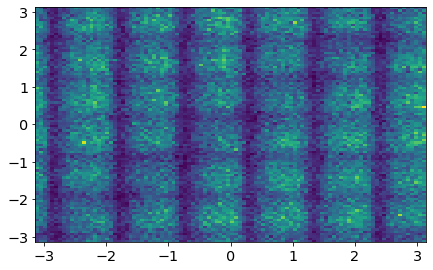

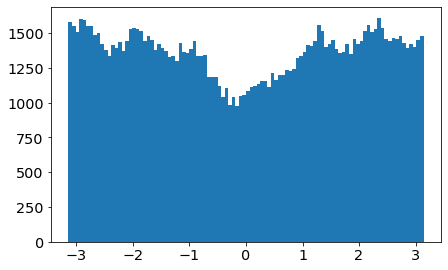

In [107]:
df = mixed.query('h2_z>0.2 and h2_cm_pt>0.3 and h1_cm_pt>0.3 and diff_rap_cm > 1.5')
df = mixed.query('h2_cm_pt>0.2')
plt.hist2d(df.h1_ph,df.h2_ph,bins=100)
plt.show()

def angle(a):
    return a+2*np.pi*(a<-np.pi)-2*np.pi*(a>np.pi)
plt.hist(angle(df.h1_ph-df.h2_ph),bins=100)
plt.show()

In [ ]:
for df0 in data_dihadrons, mc_dihadrons:
    df.histogram

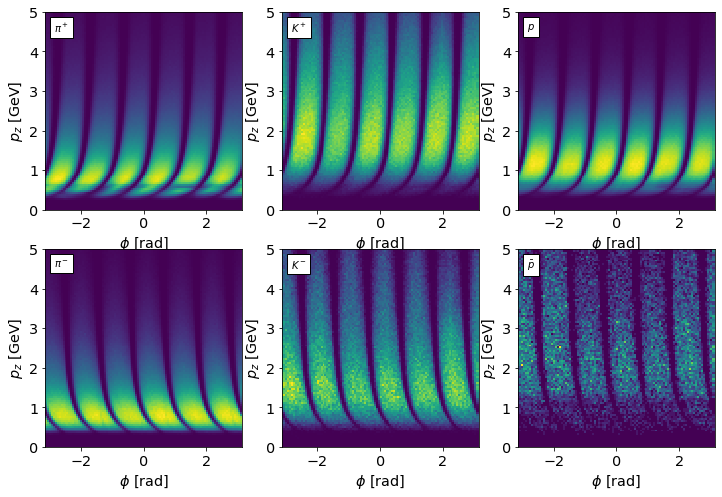

In [65]:
fig,axs = plt.subplots(2,3, figsize=(12, 8))
for j,(pid,name) in enumerate(((211,"$\\pi^+$"), (-211,"$\\pi^-$"), (321,"$K^+$"),
                                (-321,"$K^-$"),(2212,"$p$"),(-2212,"$\\bar p$"))):
    df = data_hadrons.query("h_pid == " + str(pid))
    plt.sca(axs[j%2][j//2])
    plt.hist2d(df.h_ph, df.h_pz, bins=100, range=((-np.pi, np.pi),(0,5)))
    plt.gca().add_artist(AnchoredText(name,loc='upper left'))
    plt.gca().set_xlabel("$\phi$ [rad]")
    plt.gca().set_ylabel("$p_z$ [GeV]")
plt.savefig("../images/phi_vs_pz.pdf")

In [ ]:
#use pseudorapidity since rapidity isn't in the mc tuples yet
#mc_dihadrons['h1_cm_rap']= mc_dihadrons['h1_cm_eta']
#mc_dihadrons['h2_cm_rap']= mc_dihadrons['h2_cm_eta']
#mix(mc_dihadrons)

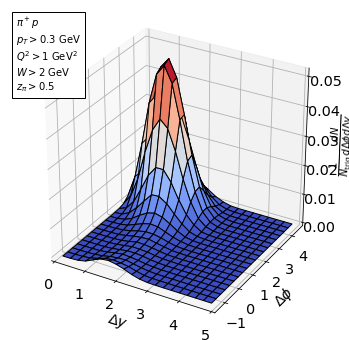

In [79]:

def offset(a):
    return a+2*np.pi*(a<-np.pi/2)-2*np.pi*(a>3*np.pi/2)

def dphi_deta_plot(df,df_mixed,df_trig,deta_range=(-2,6),bins=20,fig=None):
    dphi_range = (-np.pi/2,3*np.pi/2)
    x = df.diff_rap_cm
    y = offset(df.diff_phi_cm)
    if fig == None:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[deta_range, dphi_range])
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist = np.divide(hist, denom)
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax.plot_surface(xpos, ypos, hist.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax.set_xlabel("$\\Delta y$")
    ax.set_ylabel("$\\Delta\\phi$")
    ax.set_zlabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=-90)
    ax.set_xlim(*deta_range)
    ax.set_ylim(*dphi_range)
    return fig,ax
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
df_trig = data_triggers.query("h_cm_pt>0.3")
fig,ax = dphi_deta_plot(df,df_trig,
              deta_range=(0,5))
plt.gca().add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pi_p.pdf",bbox_inches='tight')
plt.show()

In [282]:

def offset(a):
    return a+2*np.pi*(a<-np.pi/2)-2*np.pi*(a>3*np.pi/2)
def dphi_deta_plot_3(df,df_mixed,df_trig,deta_range=(-1.5,2.5),bins=20,fig=None):
    dphi_range = (-np.pi/2,3*np.pi/2)
    if fig == None:
        fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(131, projection='3d')
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist1, xedges, yedges = np.histogram2d(df.diff_rap_cm, offset(df.diff_phi_cm), bins=bins, range=[deta_range, dphi_range])
    hist1 = np.divide(hist1, denom)
    print(xedges)
    hist2, xedges, yedges = np.histogram2d(df_mixed.diff_rap_cm, offset(df_mixed.diff_phi_cm), bins=bins, range=[deta_range, dphi_range])
    
    for i in range(bins):
        if xedges[i+1]>0:
            break
    for j in range(bins):
        if yedges[j+1]>0:
            break;
    denom = hist2[i][j]
    
    hist2 = np.divide(hist2,denom)
    
    
    hist3 = np.divide(hist1,hist2)
    
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax1.plot_surface(xpos, ypos, hist1.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax1.set_xlabel("$\\Delta y$")
    ax1.set_ylabel("$\\Delta\\phi$")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_title("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=0)
    ax1.set_xlim(*deta_range)
    ax1.set_ylim(*dphi_range)
    
    
    ax2 = fig.add_subplot(132, projection='3d')
    surf = ax2.plot_surface(xpos, ypos, hist2.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax2.set_xlabel("$\\Delta y$")
    ax2.set_ylabel("$\\Delta\\phi$")
    ax2.zaxis.set_rotate_label(False)
    ax2.set_title("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$ mix",rotation=0)
    ax2.set_xlim(*deta_range)
    ax2.set_ylim(*dphi_range)
    
    
    
    ax3 = fig.add_subplot(133, projection='3d')
    surf = ax3.plot_surface(xpos, ypos, hist3.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax3.set_xlabel("$\\Delta y$")
    ax3.set_ylabel("$\\Delta\\phi$")
    ax3.zaxis.set_rotate_label(False)
    ax3.set_title("$C(\\Delta\\phi,\\Delta y)$",rotation=0)
    ax3.set_xlim(*deta_range)
    ax3.set_ylim(*dphi_range)
    
    
    return fig,[ax1,ax2,ax3]

In [ ]:
def v2_plot(df, df_mixed, )

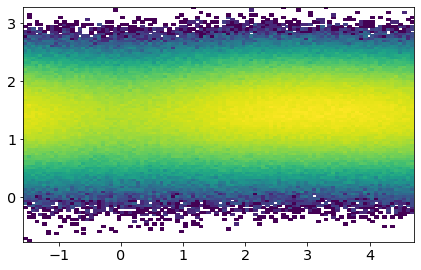

In [245]:
import matplotlib as mpl
df = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and abs(h1_pid) == 211")
plt.hist2d(offset(df.diff_phi_cm),df.diff_rap_cm,norm=mpl.colors.LogNorm(), bins=100)
plt.show()

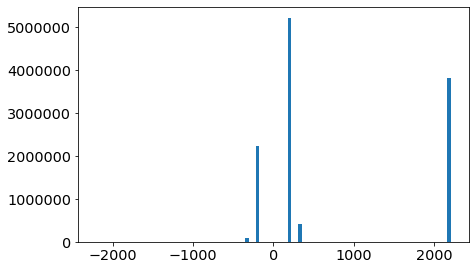

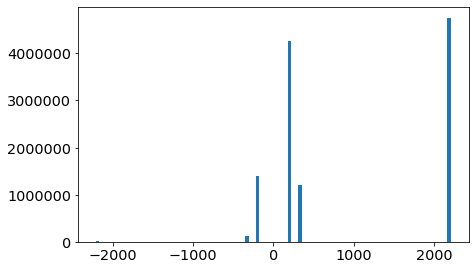

In [189]:
plt.hist(mixed.h2_pid, bins=100)
plt.show()
plt.hist(mixed.h1_pid, bins=100)
plt.show()

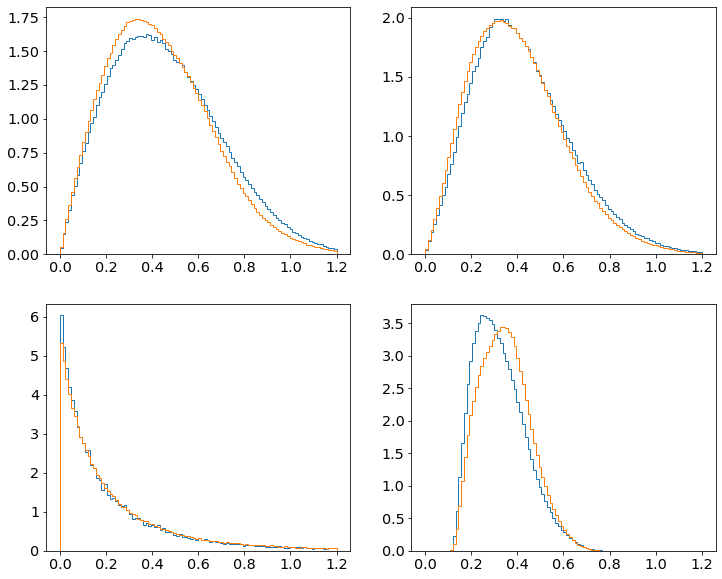

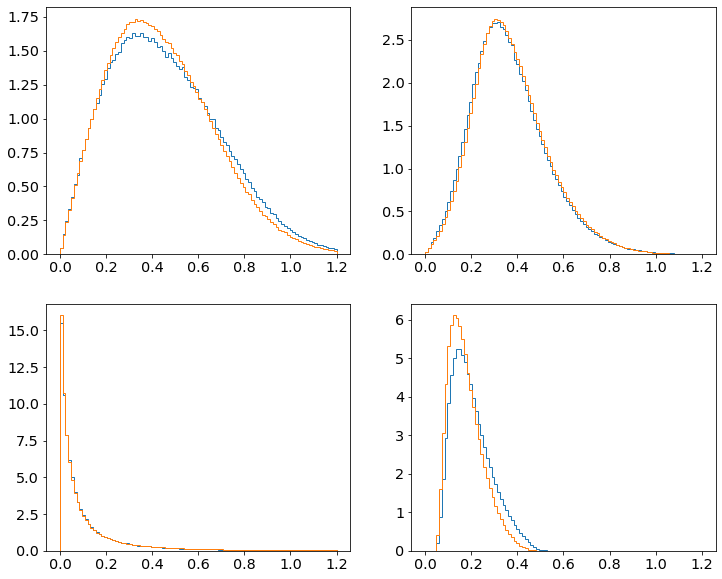

In [95]:

for q in 'h2_pid == 2212', 'abs(h2_pid) == 211':
    fig,axs = plt.subplots(2,2, figsize=(12,10))
    for df in data_dihadrons, mc_dihadrons:
        df = df.query(q)
        axs[0][0].hist(df.h1_cm_pt,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[0][1].hist(df.h2_cm_pt,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[1][0].hist(df.diff_rap_cm-df.diff_eta_cm,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[1][1].hist(df.h2_z,density=True,bins=100, histtype='step',range=(0,1.2))


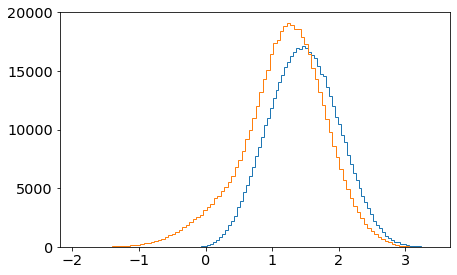

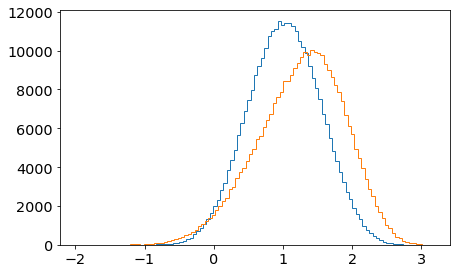

In [79]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
plt.hist(df.diff_rap_cm,bins=100,histtype='step')
plt.hist(df.mix_diff_rap,bins=100,histtype='step')
plt.show()
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
plt.hist(df.diff_rap_cm,bins=100,histtype='step')
plt.hist(df.mix_diff_rap,bins=100,histtype='step')
plt.show()

In [136]:
import misc_util

def azimuthalPlot(df,df_mixed, ntrig_real, ntrig_mixed, n=4,bins = 50, includeResiduals=False,includeLegend=True,style='normal',
                 normalize_properly=True,show='corr',frame='cm',truth=False):
    if(includeResiduals):
        fig,axs = plt.subplots(2,1, figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]}, 
                              sharex='all')
        plt.sca(axs[0])
    x,y,dy = [],[],[]
    
    if frame == 'cm':
        diff_phi_shift = offset(df.diff_phi_cm)
        mix_diff_phi_shift = offset(df_mixed.diff_phi_cm)
    elif frame== 'lab':
        if not truth:
            diff_phi_shift = offset(df.diff_phi_lab)
            mix_diff_phi_shift = offset(df_mixed.diff_phi_lab)
        else:
            diff_phi_shift = df.diff_phi_shift_lab_truth
            mix_diff_phi_shift = df.query('mix_found > 0').mix_diff_phi_shift_lab_truth
    
    denom = ntrig_real*2*np.pi/bins
    y, x = np.histogram(diff_phi_shift, bins=bins, range=(-np.pi/2,3*np.pi/2))
    x = np.add(x[1:],x[:-1])/2
    dy = np.sqrt(y)
    y=np.divide(y,denom)
    dy=np.divide(dy,denom)
    
    denom = ntrig_mixed*2*np.pi/bins
    ym, _ = np.histogram(mix_diff_phi_shift, bins=bins, range=(-np.pi/2,3*np.pi/2))
    dym = np.sqrt(ym)
    ym=np.divide(ym,denom)
    dym=np.divide(dym,denom)
    if show == 'corr':
        dy = y/ym*np.hypot(dy/y, dym/ym)
        y= y/ym
    elif show == 'mix':
        y=ym
        dy = dym
    
    
    if style== 'normal':
        plt.errorbar(x,y,dy,marker='o',color='k',linestyle='')
        plt.axhline(0,color='0.7',linestyle=':')
        #a = [2*sum(y*np.sin(i*x))/len(x) for i in range(0,n+1)]
        #remove sin term
        #a = [0 for i in range(0,n+1)]
        b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]
        b[0]/=2
        s = 0
        for i in range(0,n+1):
            s = b[i]*np.cos(i*x)+s
        plt.plot(x,s,linestyle='-',color='k',label='all')
        for i in range(1,n+1):
            plt.plot(x,b[i]*np.cos(i*x)+b[0]*(i!=0),linestyle='--', label="n=%s"%i)
        plt.gca().set_xlim(-np.pi/2,np.pi*3/2)
        if show == 'same':
            plt.gca().set_ylabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi}$",rotation=0,fontsize=20,labelpad=25)
        elif show == 'corr' :
            plt.gca().set_ylabel("$C(\\Delta\\phi)$",rotation=0,fontsize=20,labelpad=25)
        elif show == 'mix' :
            plt.gca().set_ylabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN^{\\mathrm{mix}}}{d\\Delta\\phi}$",rotation=0,fontsize=20,labelpad=25)
                
    elif style=='bar':
        plt.gca().bar(x,y,x[1]-x[0],alpha=0.3,color='tab:pink')
    if not includeResiduals:
        plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
    if includeLegend:
        legend = plt.gca().legend(title="Fourier fit",loc='upper left')
        plt.setp(legend.get_title(),fontsize=12)
    if includeResiduals:
        plt.sca(axs[1])
        plt.errorbar(x,(y-s)/dy,1,marker='o',color='k',linestyle='')
        plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
        axs[1].set_ylabel('normed residual')
        #lims = axs[0].get_ylim()
        #axs[1].set_ylim(-(lims[1]-lims[0])/6,(lims[1]-lims[0])/6)
        plt.sca(axs[0])
        plt.subplots_adjust(hspace=0)

In [153]:
def azimuthalPlot_3(df_real,df_mixed,ntrig_real, ntrig_mixed,n=4,bins = 50, includeResiduals=False,includeLegend=True,style='normal',
                 normalize_properly=True,frame='cm',truth=False):
    fig,axs = plt.subplots(1,3, figsize=(18,6))
    plt.sca(axs[0])
    azimuthalPlot(df_real,df_mixed,ntrig_real, ntrig_mixed,n,bins,includeLegend=True,show='same',frame=frame,truth=truth)
    plt.sca(axs[1])
    axs[0].get_shared_y_axes().join(axs[0], axs[1])
    azimuthalPlot(df_real,df_mixed,ntrig_real, ntrig_mixed, n,bins,includeLegend=False,show='mix',frame=frame,truth=truth)
    plt.sca(axs[2])
    azimuthalPlot(df_real,df_mixed,ntrig_real, ntrig_mixed, n,bins,includeLegend=False,show='corr',frame=frame,truth=truth)
    fig.subplots_adjust(wspace=0.4)
    return fig, axs

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 315514., 301028., 286118., 274175., 259918., 248240.,
        236777., 226403., 217260., 206886., 197862., 190165., 182365.,
        175013., 167416., 161653., 155499., 149685., 143933., 139040.,
        134014., 129623., 125141., 120587., 116746., 113333., 109739.,
        106323., 102707.,  99321.,  95848.,  92367.,  89319.,  86488.,
         83890.,  81859.,  78960.,  76757.,  74390.,  72088.,  70605.,
         67606.,  65856.,  63056.,  61405.,  60235.,  59230.,  55958.,
      

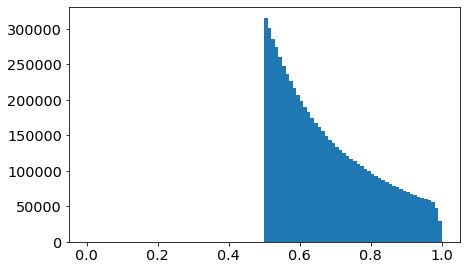

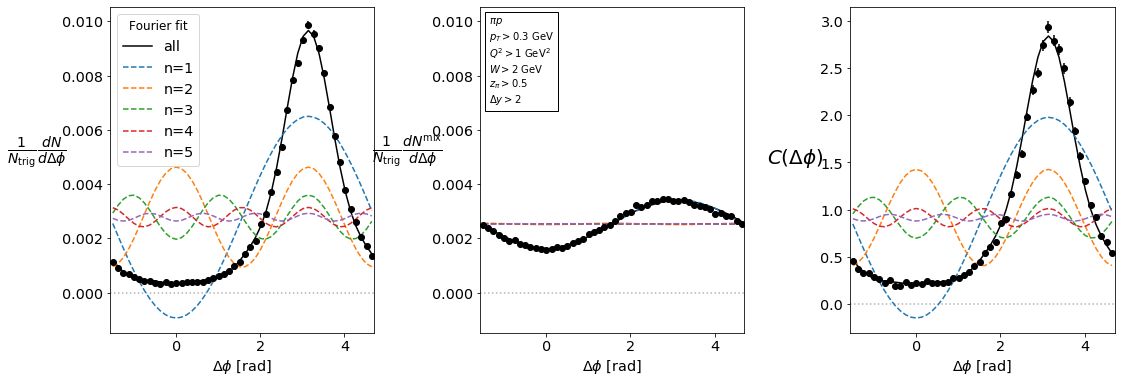

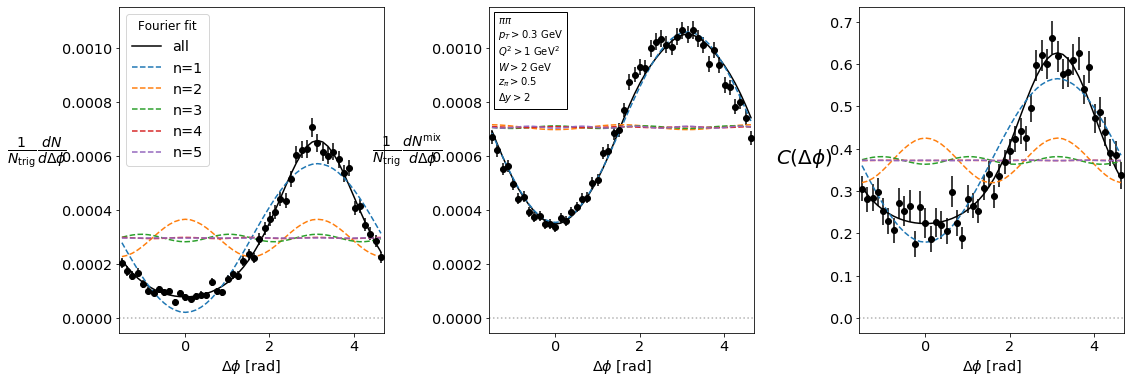

In [172]:
#cm frame

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3 and diff_rap_cm>2"\
                         + "and h2_pid == 2212")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3 and diff_rap_cm>2"\
                         + "and h2_pid == 2212")
ntrig_mixed = len(mixed.query("h1_cm_pt>0.3"))
ntrig_real = len(data_triggers.query("h_cm_pt>0.3"))

fig,axs = azimuthalPlot_3(df,df_mixed, ntrig_real, ntrig_mixed,n=5)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.savefig("../images/corr_1d_pi_p.pdf")
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3 and diff_rap_cm>2"\
                         + "and abs(h2_pid) == 211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3 and diff_rap_cm>2"\
                         + "and abs(h2_pid) == 211")

fig,axs = azimuthalPlot_3(df,df_mixed,ntrig_real,ntrig_mixed,n=5)
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.savefig("../images/corr_1d_pi_pi.pdf")
plt.show()

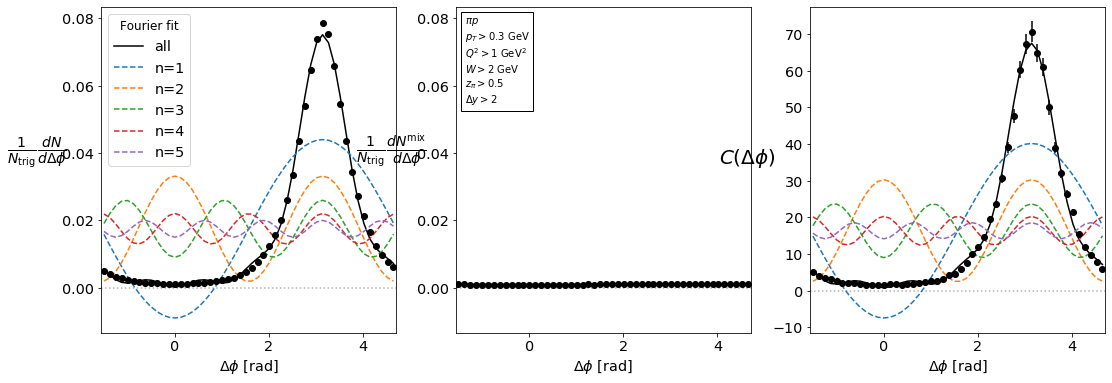

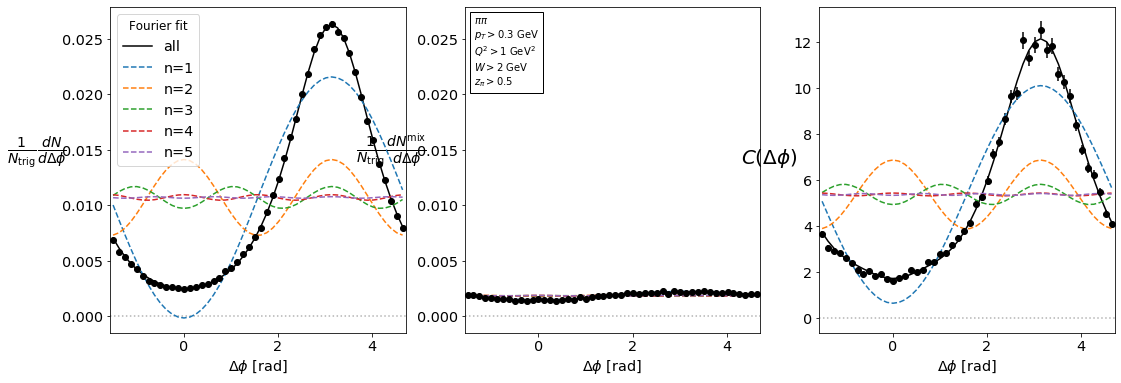

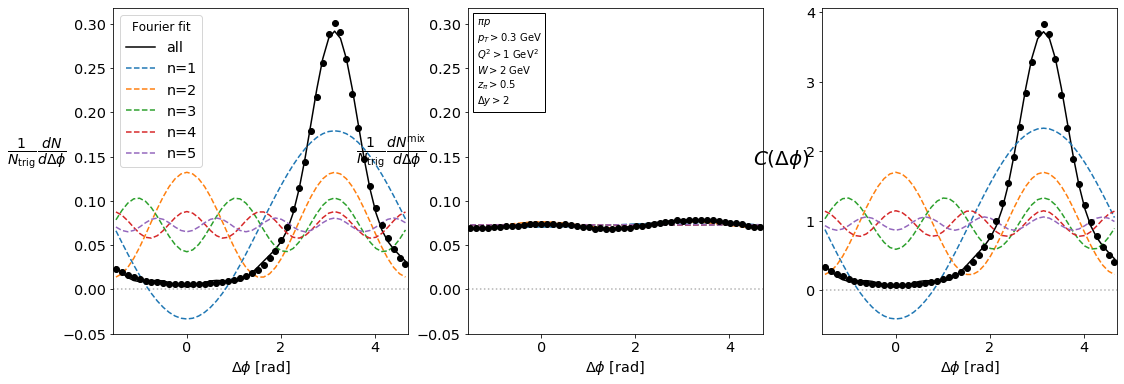

In [27]:
#cm frame  (MC)
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()


MC RECON


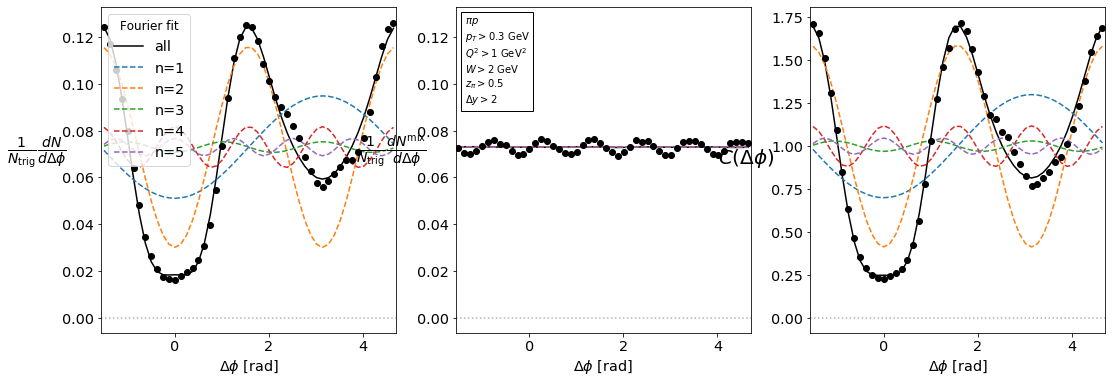

MC TRUTH


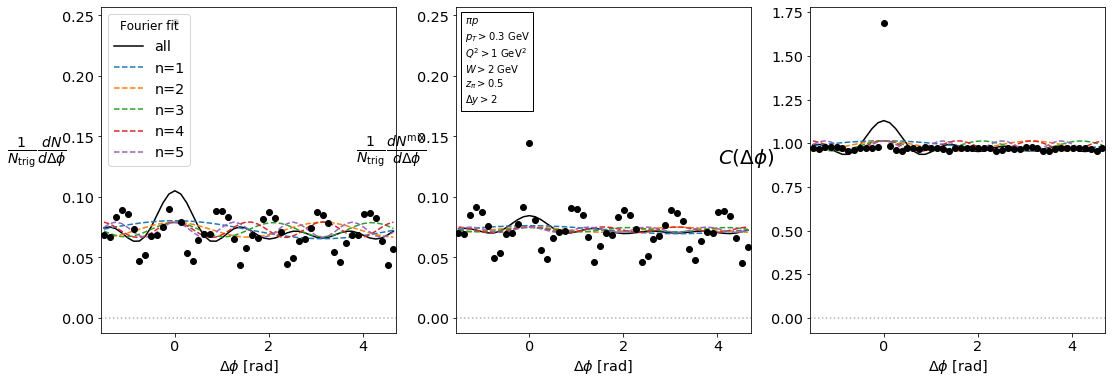

In [28]:
#lab frame MC
print("MC RECON")
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()
#lab frame MC TRUTH

print("MC TRUTH")
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab',truth=True)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()

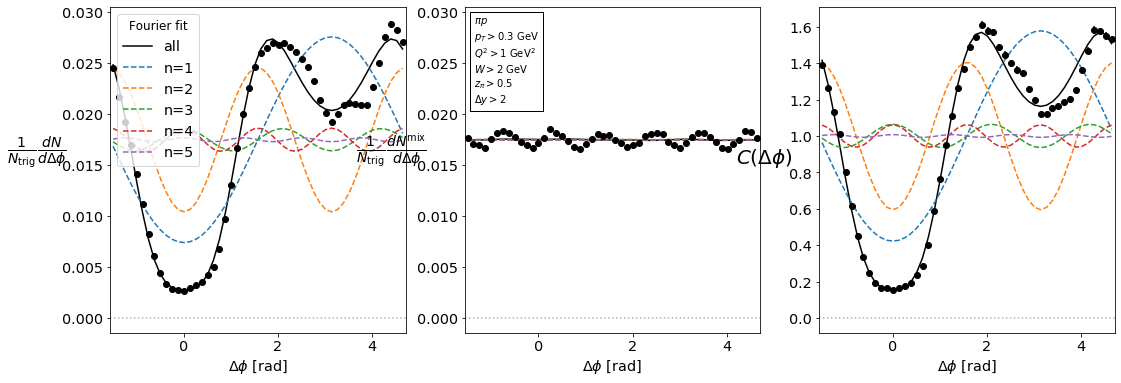

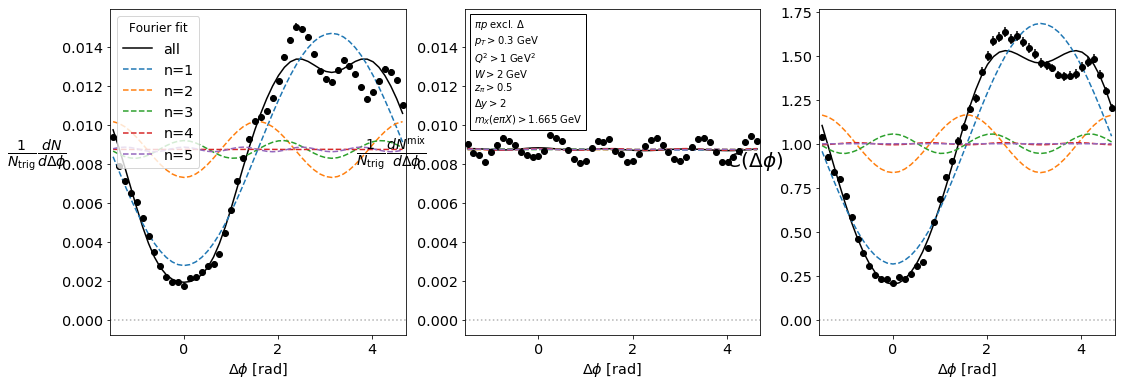

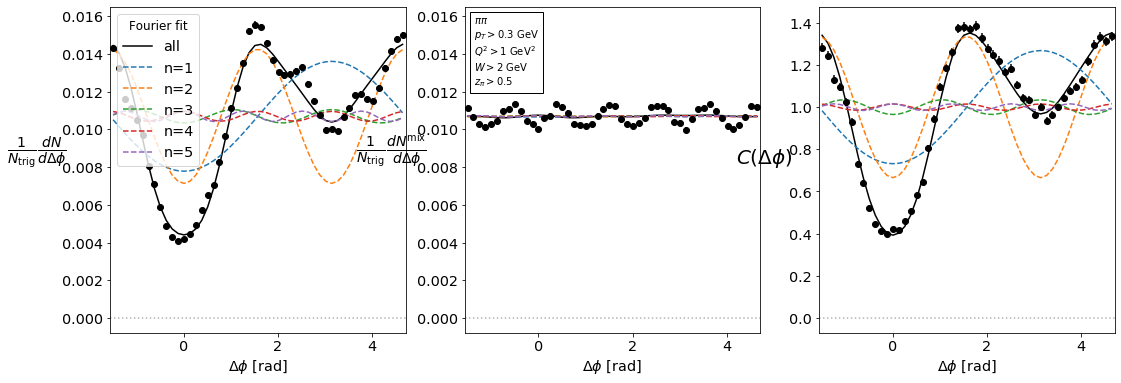

In [29]:
#lab frame
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and mx_eh1x > 1.665")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$ excl. $\Delta$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$\n$m_X(e\\pi X)> 1.665$ GeV",loc='upper left'))
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

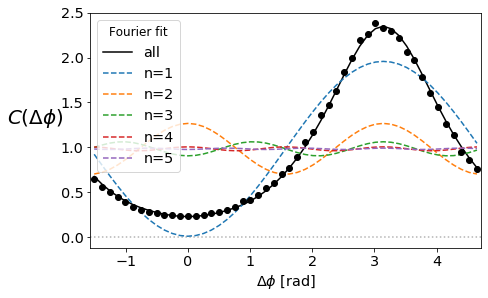

In [96]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
azimuthalPlot(df,df_trig,n=5)

<ipython-input-24-e7abf3efcec0>:34: RuntimeWarning: invalid value encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-24-e7abf3efcec0>:35: RuntimeWarning: invalid value encountered in true_divide
  y= y/ym


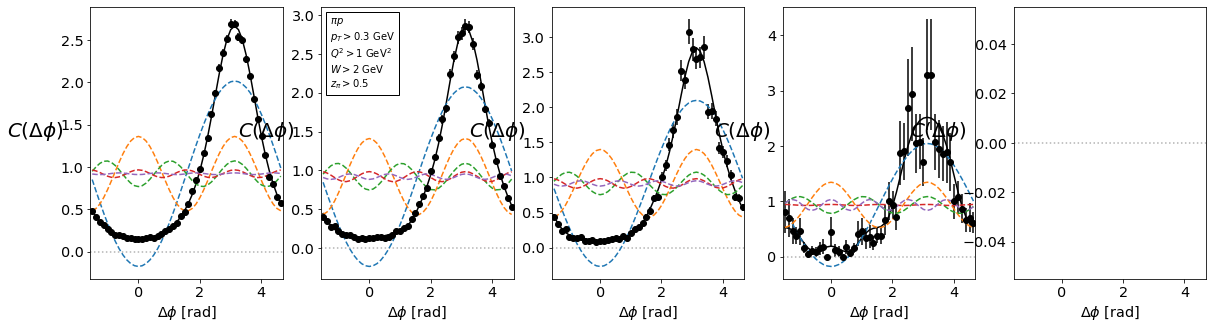

In [30]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and mx_eh1x >1.665")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()
            

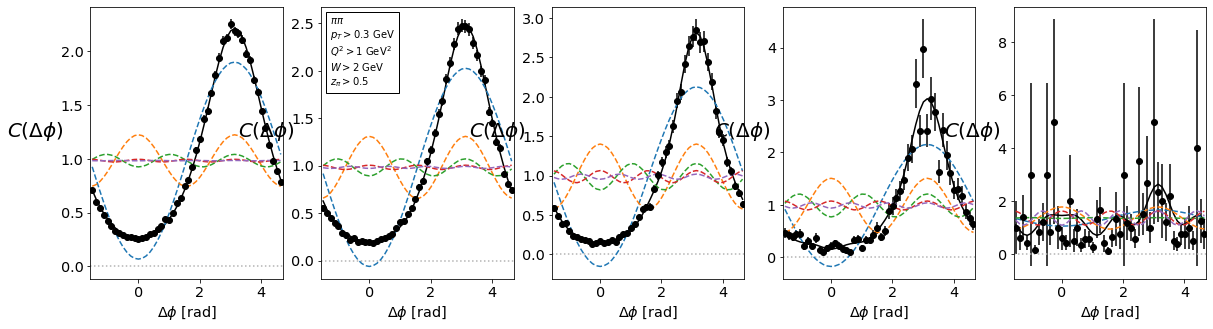

In [123]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

<ipython-input-107-86d04697ff2b>:24: RuntimeWarning: invalid value encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-107-86d04697ff2b>:24: RuntimeWarning: divide by zero encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-107-86d04697ff2b>:25: RuntimeWarning: divide by zero encountered in true_divide
  y= y/ym
<ipython-input-107-86d04697ff2b>:37: RuntimeWarning: invalid value encountered in double_scalars
  b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]


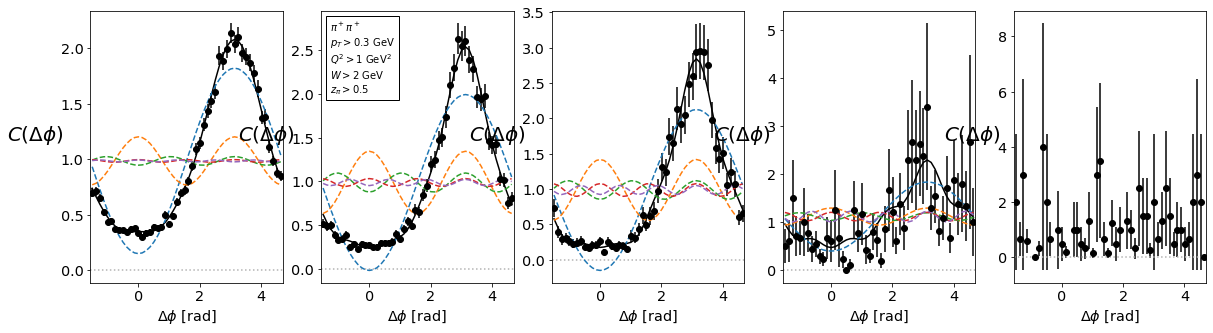

In [124]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 211 and h1_pid == 211")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi^+\pi^+$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

(array([      0.,       0.,       0.,       0.,       0., 1672821.,
              0.,       0.,       0.,       0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

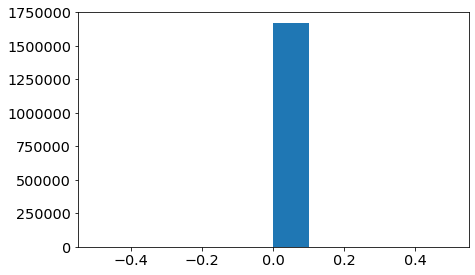

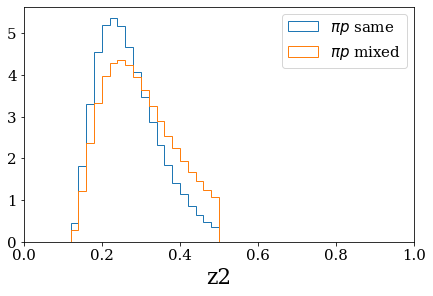

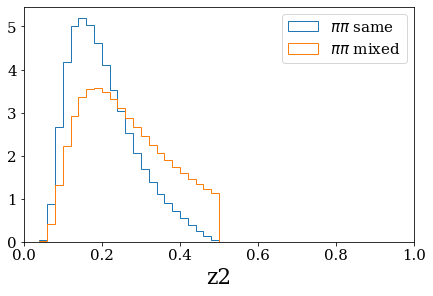

In [478]:
plt.hist(pi_p_mXcut.h2_z,bins=100,histtype='step',density=True,range=(0,2),label='$\pi p$ same')
plt.hist(pi_p_mXcut_mixed.h2_z,bins=100,histtype='step',density=True,range=(0,2),label='$\pi p$ mixed')
plt.gca().set_xlim(0,1)
plt.gca().set_xlabel("z2")
plt.legend()
plt.savefig("../images/z2_pi_p.pdf",bbox_inches='tight')
plt.show()
plt.hist(pi_pi.h2_z,bins=100,histtype='step',density=True,range=(0,2),label='$\pi\pi$ same')
plt.hist(pi_pi_mixed.h2_z,bins=100,histtype='step',density=True,range=(0,2),label='$\pi \pi$ mixed')
plt.gca().set_xlim(0,1)
plt.gca().set_xlabel("z2")
plt.legend()
plt.savefig("../images/z2_pi_pi.pdf",bbox_inches='tight')
plt.show()

In [ ]:
plt.hist(pi_p.h2_z,bins=100,histtype='step',density=True)
plt.hist(pi_p_mixed.h2_z,bins=100,histtype='step',density=True)